<a href="https://colab.research.google.com/github/micah-shull/loan_defaults/blob/main/loan_defaults_018_feature_selection_wrapper_methods_RF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data Description

This dataset contains information on clients' credit card behavior, provided by a financial institution in Taiwan. The target variable is `default_payment_next_month`, which indicates whether the client defaulted on their credit card payment the next month.

url = https://archive.ics.uci.edu/dataset/350/default+of+credit+card+clients

#### Variables:

- **ID**: ID of each client.
- **LIMIT_BAL**: Amount of given credit in NT dollars (includes individual and family/supplementary credit).
- **SEX**: Gender (1 = male, 2 = female).
- **EDUCATION**: Education level (1 = graduate school, 2 = university, 3 = high school, 4 = others, 5 = unknown, 6 = unknown).
- **MARRIAGE**: Marital status (1 = married, 2 = single, 3 = others).
- **AGE**: Age in years.

#### Payment History (PAY_X):
- **PAY_0**: Repayment status in September 2005 (-1 = pay duly, 1 = payment delay for one month, 2 = payment delay for two months, ... 8 = payment delay for eight months, 9 = payment delay for nine months and above).
- **PAY_2**: Repayment status in August 2005.
- **PAY_3**: Repayment status in July 2005.
- **PAY_4**: Repayment status in June 2005.
- **PAY_5**: Repayment status in May 2005.
- **PAY_6**: Repayment status in April 2005.

#### Bill Statement Amount (BILL_AMT_X):
- **BILL_AMT1**: Amount of bill statement in September 2005 (NT dollars).
- **BILL_AMT2**: Amount of bill statement in August 2005 (NT dollars).
- **BILL_AMT3**: Amount of bill statement in July 2005 (NT dollars).
- **BILL_AMT4**: Amount of bill statement in June 2005 (NT dollars).
- **BILL_AMT5**: Amount of bill statement in May 2005 (NT dollars).
- **BILL_AMT6**: Amount of bill statement in April 2005 (NT dollars).

#### Previous Payment Amount (PAY_AMT_X):
- **PAY_AMT1**: Amount of previous payment in September 2005 (NT dollars).
- **PAY_AMT2**: Amount of previous payment in August 2005 (NT dollars).
- **PAY_AMT3**: Amount of previous payment in July 2005 (NT dollars).
- **PAY_AMT4**: Amount of previous payment in June 2005 (NT dollars).
- **PAY_AMT5**: Amount of previous payment in May 2005 (NT dollars).
- **PAY_AMT6**: Amount of previous payment in April 2005 (NT dollars).

- **default_payment_next_month**: Default payment indicator (1 = yes, 0 = no).

#### Explanation for Feature Reordering:
The bill statement and payment amounts are listed in reverse chronological order in the dataset. To ensure that the feature names match the actual sequence of events, we reverse the column names for `BILL_AMT` and `PAY_AMT` features so that they correctly represent the time sequence from April 2005 to September 2005.



## Load & Preprocess Data

Missing Values: 0
Missing Percentage: 0.0
Number of Duplicate Rows: 0

<class 'pandas.core.frame.DataFrame'>
Index: 29965 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   limit_bal                   29965 non-null  int64   
 1   sex                         29965 non-null  category
 2   education                   29965 non-null  category
 3   marriage                    29965 non-null  category
 4   age                         29965 non-null  int64   
 5   bill_amt_4_april            29965 non-null  int64   
 6   bill_amt_5_may              29965 non-null  int64   
 7   bill_amt_6_june             29965 non-null  int64   
 8   bill_amt_7_july             29965 non-null  int64   
 9   bill_amt_8_august           29965 non-null  int64   
 10  bill_amt_9_september        29965 non-null  int64   
 11  pay_amt_4_april             29965 non-null  int64   
 12  pay_amt_

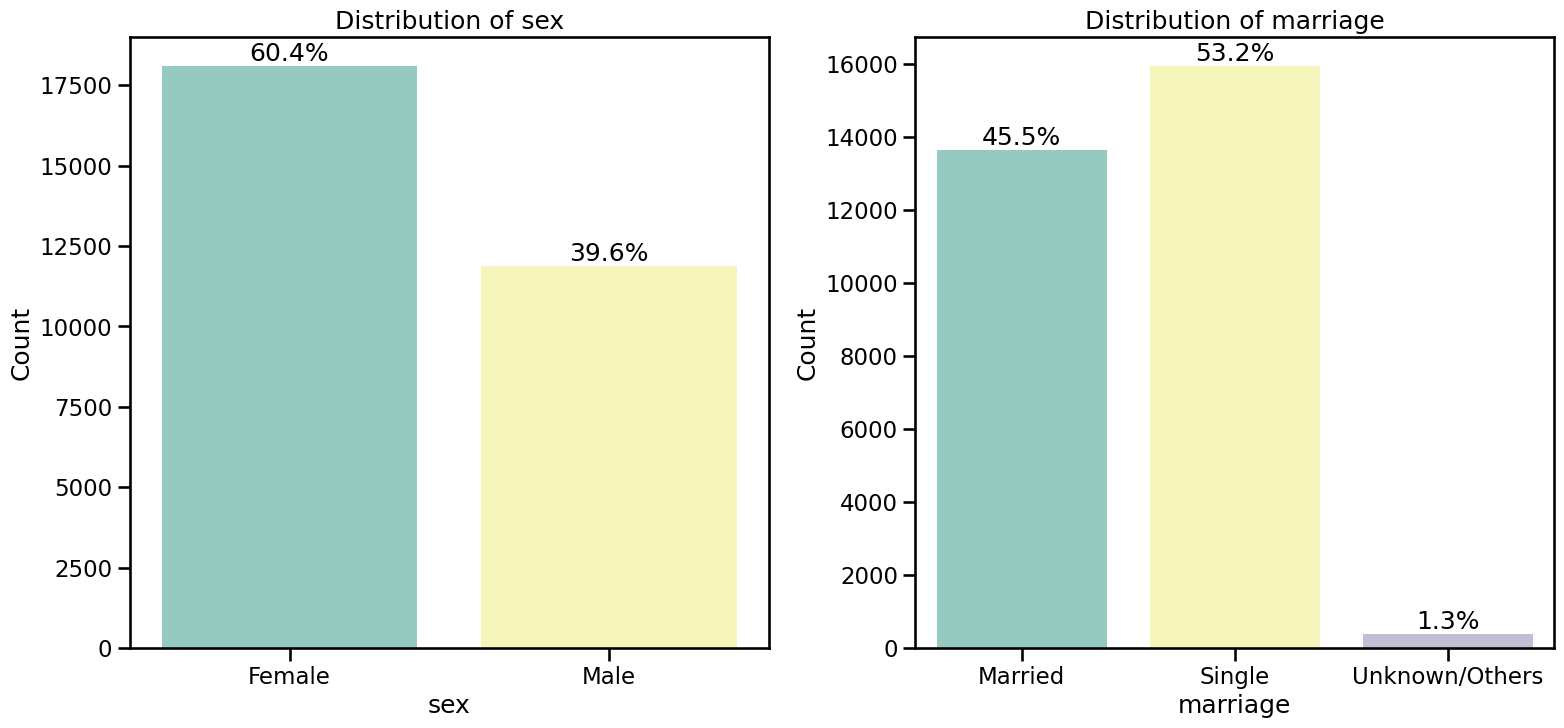

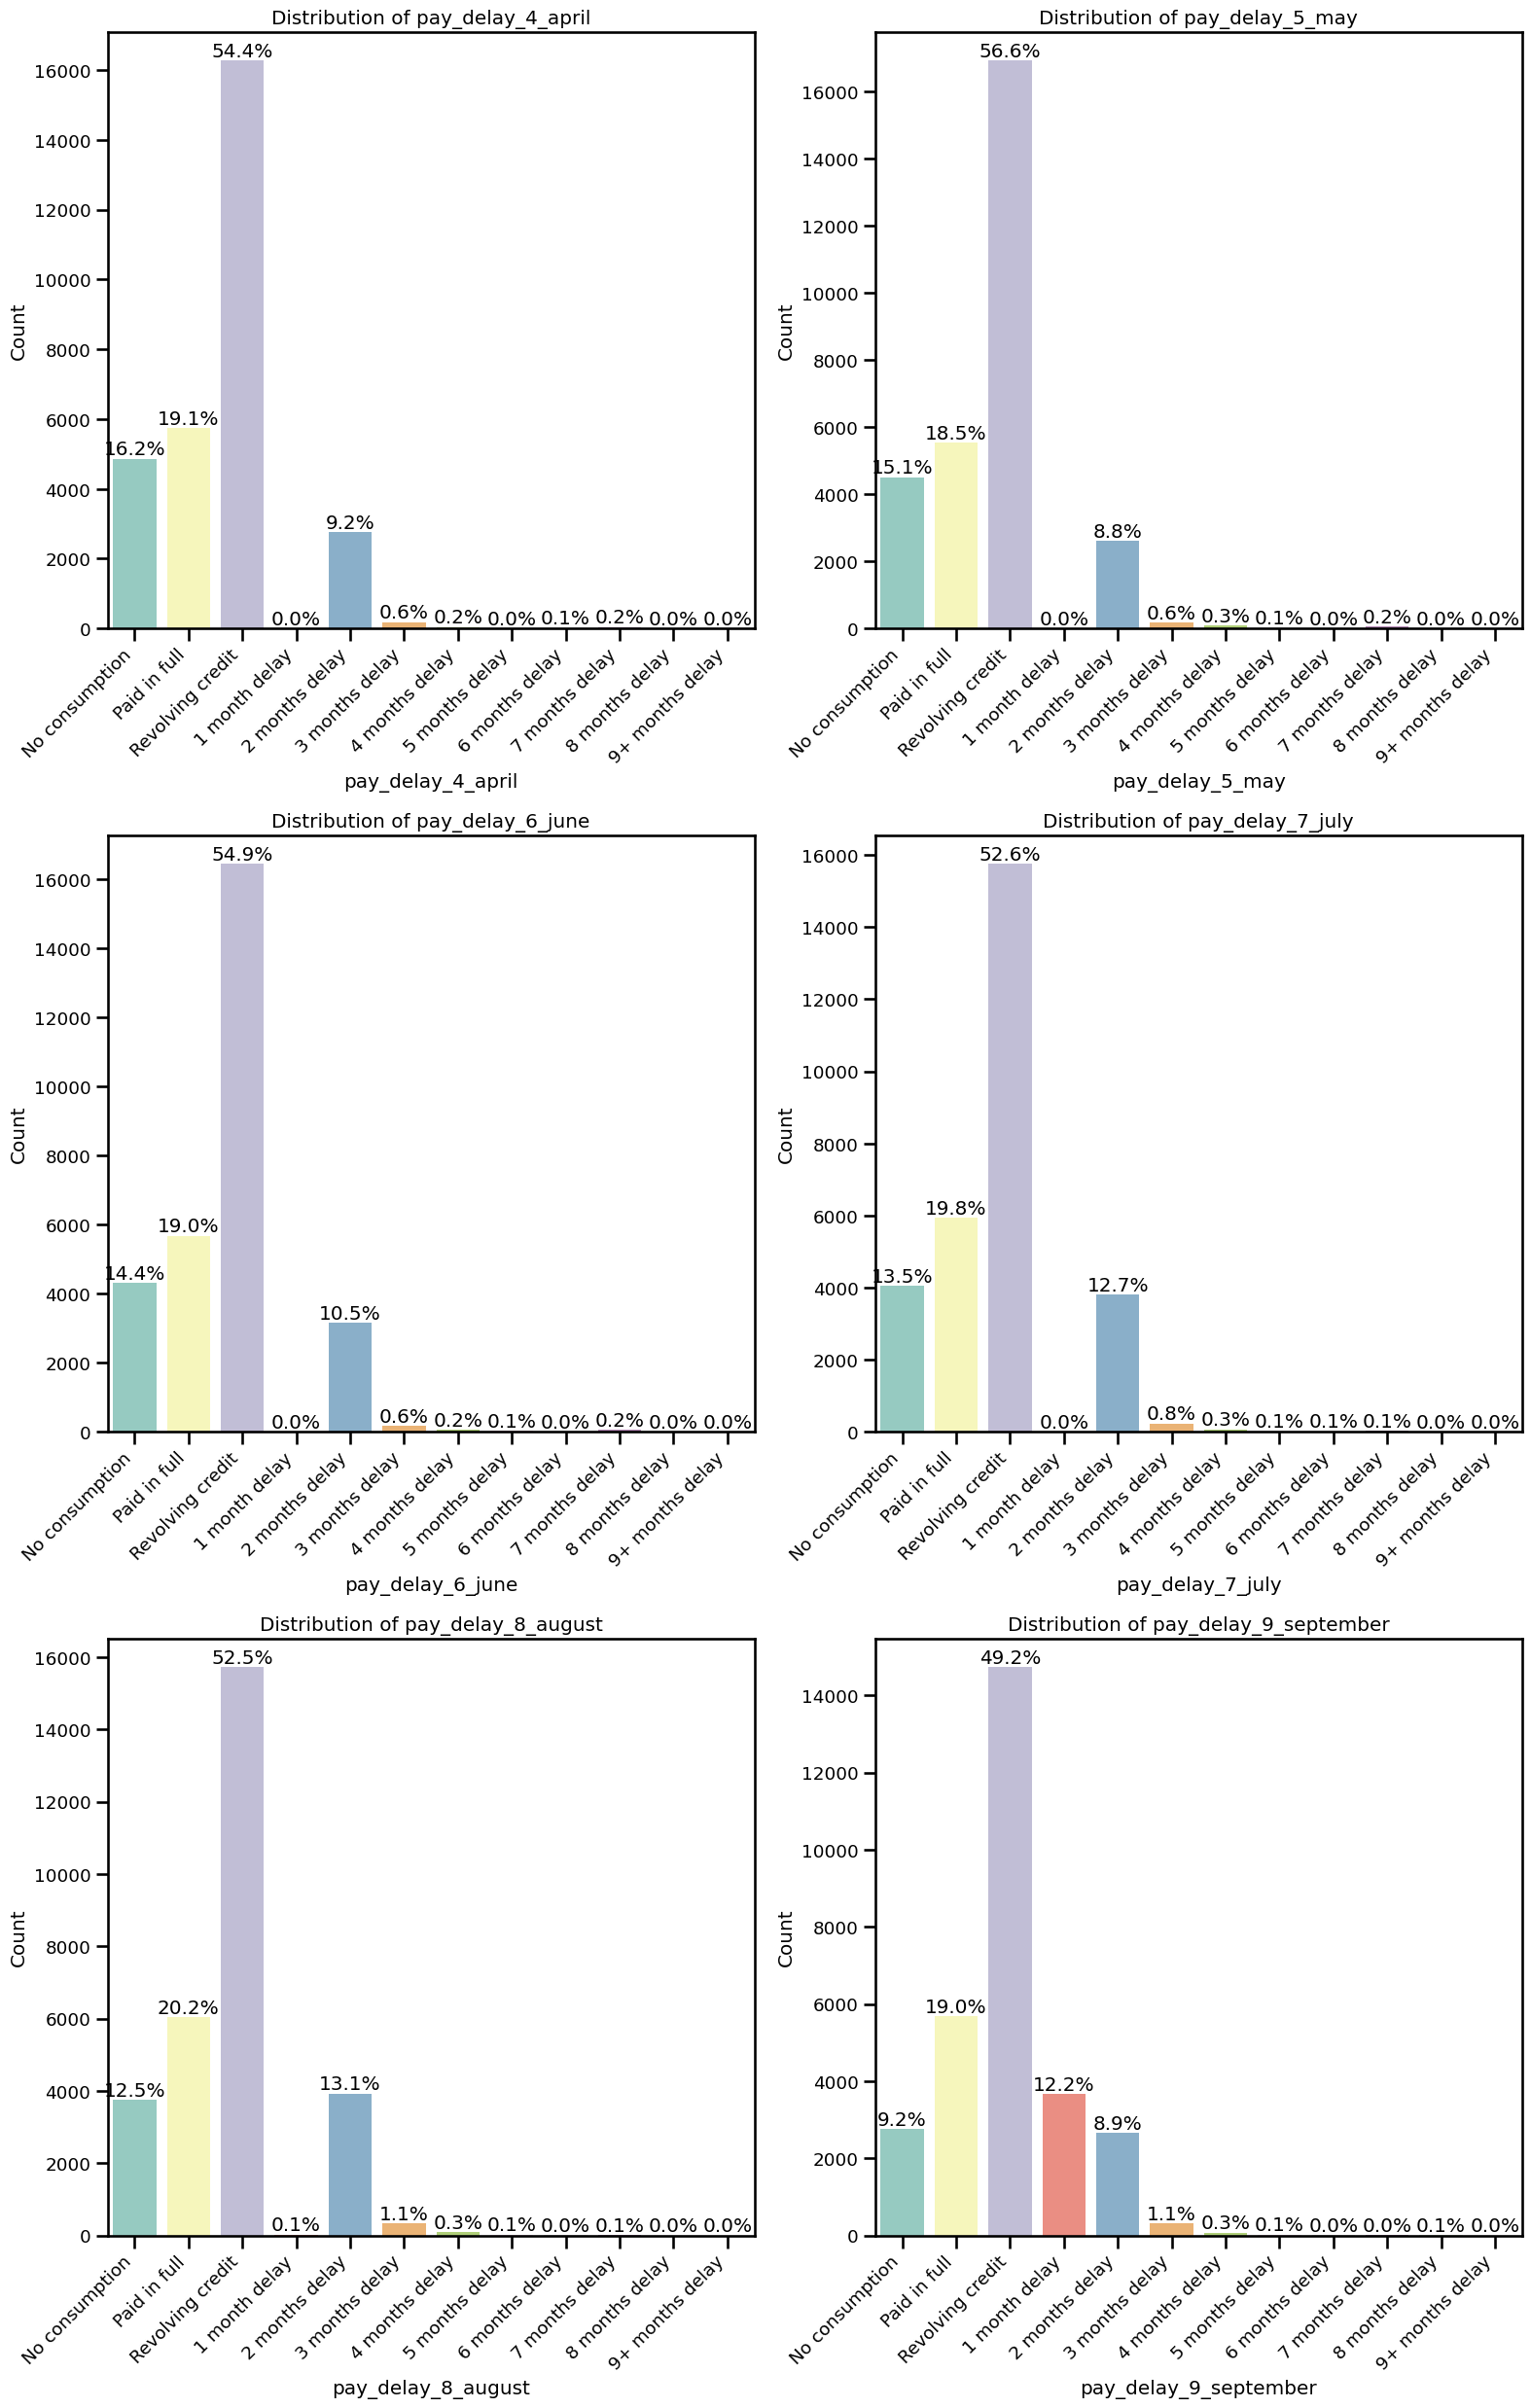

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from loan_data_utils import (load_data_from_url, clean_column_names, remove_id_column, rename_pay_columns, rename_bill_and_payment_columns,load_and_preprocess_data,
                             label_pay_columns, convert_pay_columns_to_ordinal, reorder_columns, convert_education_to_ordinal, process_sex_column, process_sex_column_cat_codes_one_two,
                             process_marriage_column, process_default_payment_column, convert_ordinal_to_category, check_column_integrity, validate_data_types,
                             check_categorical_order, primary_columns, bill_columns, pay_columns, ordinal_columns, categorical_columns,
                             plot_categorical_distributions, plot_ordinal_distributions)
from eda_utils import data_overview, plot_univariate_distributions, plot_class_distribution
import logging

# Define your URL, categorical columns, and target
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
categorical_columns = ['sex', 'marriage']
target = 'default_payment_next_month'

# Now, load the data
df = load_and_preprocess_data(url, categorical_columns, target)

if df is not None:
    # Ensure the target column is treated as a categorical variable
    df[target] = df[target].astype('category')

    # Print data overview
    data_overview(df)

    # Drop duplicate rows (optional if you didn’t remove them earlier)
    df = df.drop_duplicates()

    # Confirm the duplicates are removed
    print(f"Number of Duplicate Rows After Dropping: {df.duplicated().sum()}")

    # List of columns to check
    pay_cols = [col for col in df.columns if col.startswith('pay_delay')]

    # Check the order of categorical columns
    check_categorical_order(df, categorical_columns + pay_cols + [target])
else:
    print("Error loading and preprocessing data.")

# Convert Target to Categorical
df[target] = df[target].cat.codes  # Convert to categorical codes (0, 1)
# Check the results
print('Target converted to numeric')
print(df[target].unique())  # Should output [0, 1]

# visualize the categorical data
plot_categorical_distributions(df, categorical_columns)
plot_ordinal_distributions(df, ordinal_columns)

## Process Train & Test Data
Having all the columns as floats and scaled is generally what you want for feature selection. Here's why:

1. **Float Representation**: Feature selection methods, especially those based on statistical tests or model-based approaches, typically work best when all the features are numerical. Since all your categorical, ordinal, and boolean features have been encoded as numeric types (floats), it makes it easier to apply feature selection algorithms consistently.

2. **Scaling**: Many feature selection methods, such as those based on model coefficients (like Lasso or Ridge regression), are sensitive to the scale of the data. By scaling the features, you're ensuring that all features are treated equally during selection, regardless of their original units or ranges. This helps the selection methods better evaluate the importance of each feature.

### For Feature Selection:
- **Univariate Methods**: Methods like `SelectKBest` with ANOVA or chi-squared tests benefit from numeric, scaled data.
- **Model-Based Selection**: Approaches using models like Lasso or Ridge require scaled numeric data for optimal performance.
- **Embedded Methods**: Methods that use tree-based models or gradient boosting can still work without scaling but will perform consistently across different features when scaling is applied.

In short, having all columns as floats and scaled is ideal for the majority of feature selection techniques. You're set up well to proceed with feature selection!


In [ ]:
# Import the necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from imblearn.pipeline import Pipeline as IMBPipeline
from imblearn.over_sampling import SMOTE
from loan_data_utils import ThresholdClassifier
from feature_engineering_pipeline_utils import (HighRiskDelayFeatureTransformer, SevereDelayCountTransformer,
                                                CumulativeDelayTransformer, SevereDelayPaymentRatioTransformer,
                                                AvgPaymentSevereDelaysTransformer, DeferredAndDecreasingPaymentsTransformer,
                                                SevereDeferredAndDecreasingPaymentsTransformer, SevereDeferredAndAnyDecreasingPaymentsTransformer,
                                                TotalPaymentsTransformer, AvgPaymentTransformer, PaymentStdTransformer, WeightedPaymentSumTransformer,
                                                TotalBillsTransformer, DebtToLimitRatioTransformer, EducationMarriageInteractionTransformer,
                                                WinsorRobustOutlierRemovalTransformer, CombinedFeatureEngineeringTransformer)

# Define the target
target = 'default_payment_next_month'

# Split the data into features and target
X = df.drop(columns=[target])
y = df[target]

# Perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define the columns (numeric, categorical, ordinal, boolean)
numeric_features = ['age', 'limit_bal', 'bill_amt_4_april', 'bill_amt_5_may', 'bill_amt_6_june',
                    'bill_amt_7_july', 'bill_amt_8_august', 'bill_amt_9_september', 'pay_amt_4_april',
                    'pay_amt_5_may', 'pay_amt_6_june', 'pay_amt_7_july', 'pay_amt_8_august', 'pay_amt_9_september',
                    'severe_delay_count', 'cumulative_delay', 'severe_delay_payment_ratio', 'avg_payment_severe_delays',
                    'total_payments', 'avg_payment', 'payment_std', 'weighted_payment_sum', 'total_bills', 'debt_to_limit_ratio']
pay_columns = ['pay_amt_4_april', 'pay_amt_5_may','pay_amt_6_june', 'pay_amt_7_july','pay_amt_8_august', 'pay_amt_9_september',
               'bill_amt_4_april', 'bill_amt_5_may','bill_amt_6_june', 'bill_amt_7_july','bill_amt_8_august', 'bill_amt_9_september']
delay_columns = ['pay_delay_4_april', 'pay_delay_5_may', 'pay_delay_6_june', 'pay_delay_7_july', 'pay_delay_8_august', 'pay_delay_9_september']
bill_columns = ['bill_amt_4_april', 'bill_amt_5_may', 'bill_amt_6_june', 'bill_amt_7_july', 'bill_amt_8_august', 'bill_amt_9_september']
categorical_features = ['sex', 'marriage', 'education_marriage']
ordinal_features = ['education', 'pay_delay_4_april', 'pay_delay_5_may', 'pay_delay_6_june', 'pay_delay_7_july', 'pay_delay_8_august', 'pay_delay_9_september']
boolean_features = ['high_risk_delay', 'deferred_and_decreasing_payments', 'severe_deferred_and_decreasing_payments', 'severe_deferred_and_any_decreasing_payments']

# Step 1: Feature Engineering and Preprocessing Pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

bool_to_numeric_transformer = Pipeline(steps=[
    ('convert_bool', FunctionTransformer(lambda x: x.astype(int))),
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('ord', ordinal_transformer, ordinal_features),
        ('bool', bool_to_numeric_transformer, boolean_features)
    ]
)

# Step 1: Define the full pipeline (with SMOTE) for the training data
smote_preprocessing_pipeline = IMBPipeline(steps=[
    ('outlier_removal', WinsorRobustOutlierRemovalTransformer(columns=pay_columns)),  # Outlier removal
    ('feature_engineering', CombinedFeatureEngineeringTransformer(delay_columns, pay_columns, bill_columns)),  # Feature engineering
    ('preprocessor', preprocessor),  # Preprocessing
    ('smote', SMOTE(random_state=42))  # SMOTE for resampling
])

# Step 2: Define the preprocessing pipeline for the test data (without SMOTE)
test_preprocessing_pipeline = Pipeline(steps=[
    ('outlier_removal', WinsorRobustOutlierRemovalTransformer(columns=pay_columns)),  # Outlier removal
    ('feature_engineering', CombinedFeatureEngineeringTransformer(delay_columns, pay_columns, bill_columns)),  # Feature engineering
    ('preprocessor', preprocessor)  # Preprocessing (without SMOTE)
])

# Step 3: Fit the training pipeline and resample the training data
X_train_processed, y_train_resampled = smote_preprocessing_pipeline.fit_resample(X_train, y_train)

# Step 4: Fit the test preprocessing pipeline using the training data
# We need to fit the test pipeline on X_train to ensure that scaling and encoding parameters are learned from the training set
test_preprocessing_pipeline.fit(X_train)

# Step 5: Transform the test data using the test preprocessing pipeline
X_test_processed = test_preprocessing_pipeline.transform(X_test)

# Step 6: Manually Construct Feature Names
# Numeric features (after imputation and scaling)
numeric_feature_names = smote_preprocessing_pipeline.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out(numeric_features)

# Categorical features (after OneHotEncoder)
categorical_feature_names = smote_preprocessing_pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_features)

# Ordinal features (no changes, just the original names)
ordinal_feature_names = ordinal_features

# Boolean features (manually handled as they are converted to 0/1)
boolean_feature_names = boolean_features

# Combine all feature names into a single list
all_feature_names = np.concatenate([numeric_feature_names, categorical_feature_names, ordinal_feature_names, boolean_feature_names])

# Step 7: Convert the processed training and test data to DataFrames with meaningful feature names
X_train_processed_df = pd.DataFrame(X_train_processed, columns=all_feature_names)
X_test_processed_df = pd.DataFrame(X_test_processed, columns=all_feature_names)

# Step 8: Add the target variable to the training DataFrame (y_train_resampled) and test DataFrame (y_test)
X_train_processed_df['target'] = y_train_resampled
X_test_processed_df['target'] = y_test  # We don't resample y_test

# Optional: check the data types to confirm everything is as expected
print("Data types after processing (X_train):")
print(X_train_processed_df.dtypes)
print("Data types after processing (X_test):")
print(X_test_processed_df.dtypes)

# Step 9: Inspect the processed DataFrames for feature selection
print("Processed training data ready for feature selection:")
X_train_processed_df.head()
print("Processed test data ready for feature selection:")
X_test_processed_df.head()

# Step 10: (Optional) Save the processed DataFrames for feature selection
X_train_processed_df.to_csv('X_train_processed.csv', index=False)
X_test_processed_df.to_csv('X_test_processed.csv', index=False)

# Confirmation of saved processed data
print("Processed train and test data saved for feature selection.")


Data types after processing (X_train):
age                                                  float64
limit_bal                                            float64
bill_amt_4_april                                     float64
bill_amt_5_may                                       float64
bill_amt_6_june                                      float64
bill_amt_7_july                                      float64
bill_amt_8_august                                    float64
bill_amt_9_september                                 float64
pay_amt_4_april                                      float64
pay_amt_5_may                                        float64
pay_amt_6_june                                       float64
pay_amt_7_july                                       float64
pay_amt_8_august                                     float64
pay_amt_9_september                                  float64
severe_delay_count                                   float64
cumulative_delay                              

### Wrapper Methods

Wrapper methods are a type of feature selection technique where you evaluate the performance of a model with different subsets of features and choose the subset that provides the best performance. These methods wrap the model (hence the name "wrapper") in an iterative process of selecting features, training the model, and evaluating its performance.

There are two common types of wrapper methods:

1. **Forward Selection**:
   - Starts with an empty set of features.
   - Adds one feature at a time based on model performance.
   - At each step, the feature that improves the model performance the most is added to the set.

2. **Backward Elimination**:
   - Starts with all the features.
   - Removes one feature at a time based on model performance.
   - At each step, the feature that reduces performance the least is removed.

3. **Recursive Feature Elimination (RFE)**:
   - A hybrid approach where you iteratively fit a model, rank features by importance, and remove the least important ones, continuing until the desired number of features is reached.

Wrapper methods are computationally expensive but tend to be more accurate than filter methods since they directly account for the impact of each feature on model performance. They are useful when you aim to find the optimal feature subset tailored to the model you are using.




## Recursive Feature Elimination (RFE) - Select 10 Features

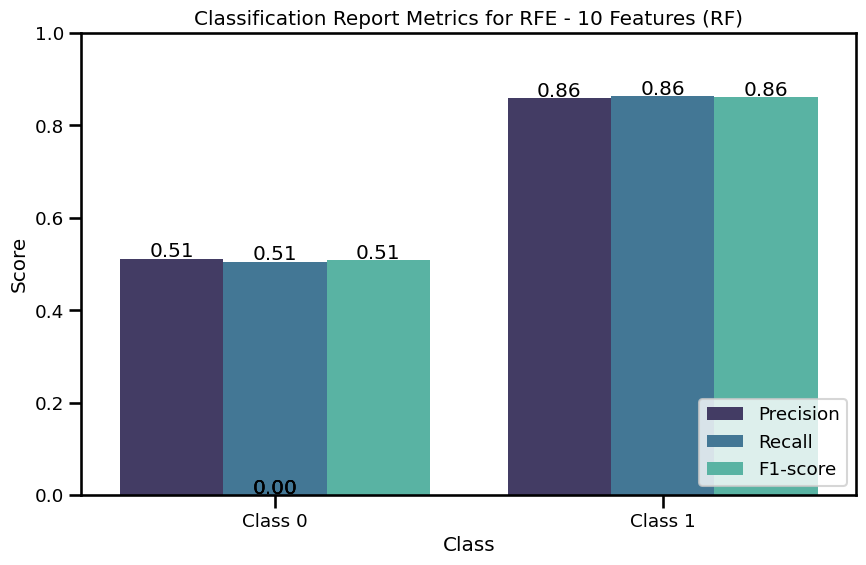

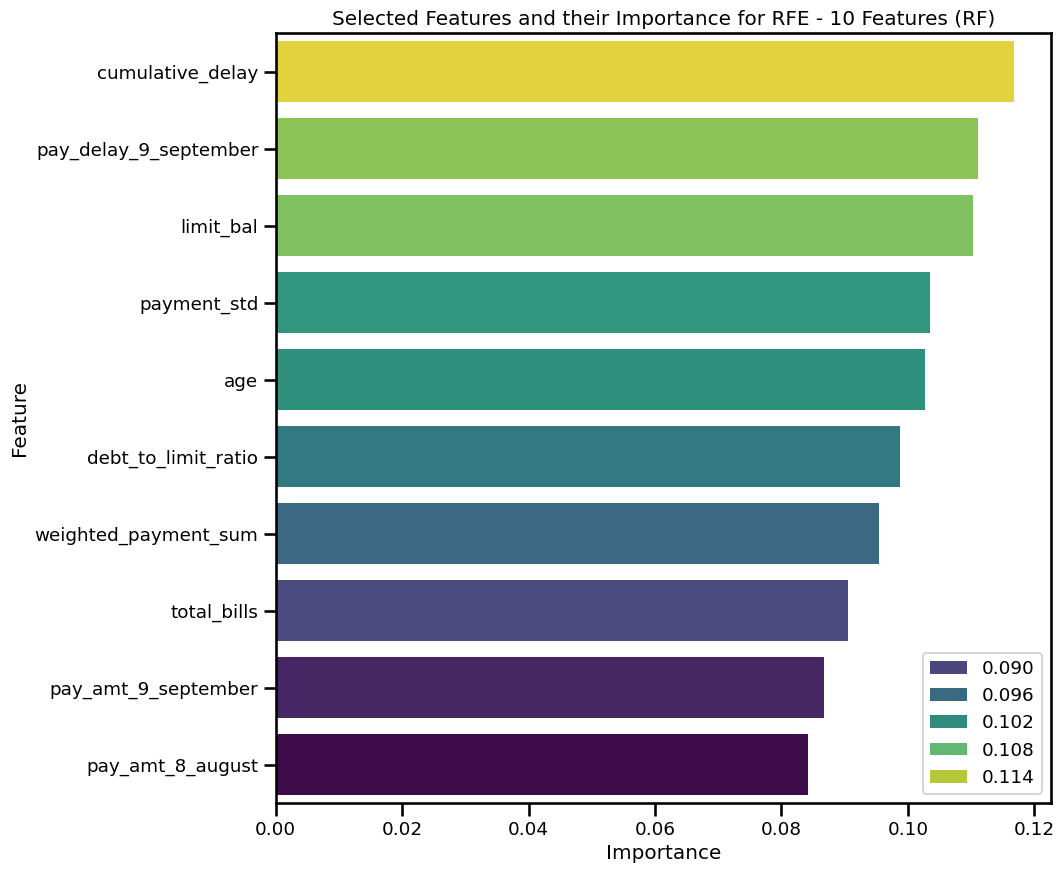

RFE feature selection with 10 features (Random Forest) completed and saved.


In [ ]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from loan_data_utils import plot_classification_report_metrics, plot_selected_features
import pandas as pd
import matplotlib.pyplot as plt
import json

# Step 1: Define the base classifier for RFE (Logistic Regression)
base_classifier = RandomForestClassifier(random_state=42)

# Step 2: Define the RFE step with the base classifier and number of features to select (10 features)
rfe = RFE(estimator=base_classifier, step=5, n_features_to_select=10)

# Step 3: Create the pipeline with feature selection and classification
pipeline_rfe = Pipeline(steps=[
    ('feature_selection', rfe),
    ('classifier', base_classifier)
])

# Step 4: Fit the pipeline to the training data
pipeline_rfe.fit(X_train_processed_df.drop(columns=['target']), y_train_resampled)

# Step 5: Predict on the test data and generate the classification report
y_pred_rfe = pipeline_rfe.predict(X_test_processed_df.drop(columns=['target']))
classification_report_rfe = classification_report(y_test, y_pred_rfe, output_dict=True)
print("Classification Report (RFE - 10 Features, Logistic Regression):")
print(classification_report(y_test, y_pred_rfe, output_dict=False))

# Step 6: Extract the selected feature names
selected_binary_features_rfe = rfe.get_support()
feature_names_rfe = X_train_processed_df.drop(columns=['target']).columns.tolist()
selected_feature_names_rfe = [feature_names_rfe[i] for i in range(len(feature_names_rfe)) if selected_binary_features_rfe[i]]

# Step 7: Extract the feature importances for the selected features using RandomForest's feature_importances_
feature_importances_rfe = rfe.estimator_.feature_importances_

# Step 8: Sort the selected features by their importance
selected_features_rfe = dict(sorted(zip(selected_feature_names_rfe, feature_importances_rfe), key=lambda item: abs(item[1]), reverse=True))

# Step 9: Initialize the results dictionary and accumulate the classification report and selected features
results = {}
selected_features = {}
results['RFE_10_features_rf'] = classification_report_rfe
selected_features['RFE_10_features_rf'] = selected_features_rfe

# Step 10: Plot the classification report metrics and selected features
plot_classification_report_metrics(classification_report_rfe, 'RFE - 10 Features (RF)')
plot_selected_features(selected_features_rfe, 'RFE - 10 Features (RF)', figsize=(10, 10))

# Step 11: Save the accumulated classification reports and selected features to JSON files
with open('classification_reports_wrapper_methods_rf.json', 'w') as f:
    json.dump(results, f, indent=4)

with open('selected_features_wrapper_methods_rf.json', 'w') as f:
    json.dump(selected_features, f, indent=4)

print("RFE feature selection with 10 features (Random Forest) completed and saved.")


## Recursive Feature Elimination (RFE) Optimal Feature Search

In feature selection, particularly with methods like **Recursive Feature Elimination (RFE)**, when you extract feature importance, the scores can be **positive** or **negative** depending on how the feature impacts the model's predictions. Here's why:

### 1. **Positive and Negative Feature Scores**:
   - **Positive scores** indicate that increasing the value of the feature is associated with the **positive class** (class 1 in a binary classification). In logistic regression, for example, it means that as the value of the feature increases, the model is more likely to predict class 1.
   - **Negative scores** suggest the opposite: increasing the value of the feature makes it more likely that the model will predict the **negative class** (class 0).

### 2. **Understanding Coefficients in Models**:
   - In models like **Logistic Regression**, the importance of a feature is represented by its **coefficient**. The magnitude of the coefficient (its absolute value) indicates the strength of the feature's impact, while the sign (positive or negative) shows the direction of the impact:
     - **Positive coefficients**: The feature increases the probability of predicting class 1.
     - **Negative coefficients**: The feature decreases the probability of predicting class 1 (i.e., increases the probability of predicting class 0).
   - For example, if a feature has a **high positive coefficient**, it is strongly pushing the model to predict the positive class. A **high negative coefficient** means it's strongly pushing toward the negative class.

### 3. **Regularization and Feature Scores**:
   - In some cases, when you use **regularization** (like L1 or L2 regularization in Logistic Regression), the model can penalize certain features to reduce their impact. This can lead to smaller coefficients (closer to zero) for less important features, but they still retain their signs depending on how they influence predictions.
  
### 4. **Why Both Positive and Negative Scores Matter**:
   - Both positive and negative feature scores are important because they tell you how the model uses the features:
     - A **positive score** tells you that the feature helps the model predict the positive class (class 1).
     - A **negative score** tells you that the feature helps the model avoid predicting the positive class and instead favors the negative class (class 0).
  
### 5. **Example in Logistic Regression**:
   - Suppose you have a logistic regression model predicting loan defaults. Let's say two features have coefficients:
     - **Income**: +2.0 (positive)
     - **Debt-to-Income Ratio**: -3.0 (negative)
     
     In this case, as **income** increases, the model is more likely to predict that the individual will not default (class 1). Conversely, as the **debt-to-income ratio** increases, the likelihood of default (class 0) increases. The larger the absolute value of these coefficients, the more significant the feature's influence on the prediction.

### 6. **Feature Importance in Tree-Based Models**:
   - In contrast, tree-based models (like Random Forest or Gradient Boosting) assign **importance scores** based on how much a feature improves the split in the tree. These scores are usually positive, and they don’t have signs because they represent how much each feature contributes to reducing prediction error.

In summary, **positive and negative scores** in feature importance reflect how the feature influences the model's predictions, either pushing it toward the positive class (class 1) or the negative class (class 0).

Evaluating RFE with 1 features...
Evaluating RFE with 6 features...
Evaluating RFE with 11 features...
Evaluating RFE with 16 features...
Evaluating RFE with 21 features...
Evaluating RFE with 26 features...
Evaluating RFE with 31 features...
Evaluating RFE with 36 features...
Evaluating RFE with 41 features...
Evaluating RFE with 46 features...
Evaluating RFE with 51 features...


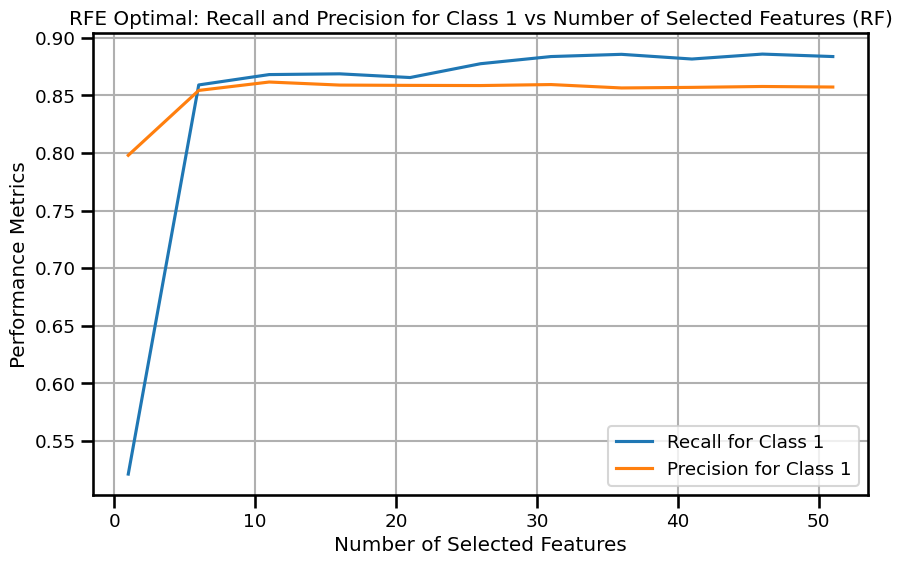

Optimal number of features based on Recall for Class 1: 46
Optimal number of features based on Precision for Class 1: 11
RFE Optimal feature selection with RF completed and saved.


In [ ]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import json

# Step 1: Define the base classifier (Random Forest)
base_classifier = RandomForestClassifier(random_state=42)

# Step 2: Initialize lists to store the results
n_features_list = list(range(1, X_train_processed_df.drop(columns=['target']).shape[1] + 1, 5))  # Increment by 5
recall_scores_class1 = []
precision_scores_class1 = []
selected_feature_dict = {}

# Step 3: Iterate over a range of n_features_to_select for RFE
for n_features in n_features_list:
    print(f"Evaluating RFE with {n_features} features...")

    # Define the RFE step with the base classifier and current n_features_to_select
    rfe = RFE(estimator=base_classifier, step=5, n_features_to_select=n_features)

    # Create the pipeline with RFE and the classifier
    pipeline_rfe = Pipeline(steps=[
        ('feature_selection', rfe),
        ('classifier', base_classifier)
    ])

    # Fit the pipeline to the training data
    pipeline_rfe.fit(X_train_processed_df.drop(columns=['target']), y_train_resampled)

    # Predict on the test data
    y_pred_rfe = pipeline_rfe.predict(X_test_processed_df.drop(columns=['target']))

    # Get the classification report
    report = classification_report(y_test, y_pred_rfe, output_dict=True)

    # Extract recall and precision for class 1 (the positive class)
    recall_class1 = report['1']['recall']
    precision_class1 = report['1']['precision']

    # Append metrics to lists
    recall_scores_class1.append(recall_class1)
    precision_scores_class1.append(precision_class1)

    # Extract selected features and save them for this iteration
    selected_binary_features_rfe = rfe.get_support()
    feature_names_rfe = X_train_processed_df.drop(columns=['target']).columns.tolist()
    selected_feature_names_rfe = [feature_names_rfe[i] for i in range(len(feature_names_rfe)) if selected_binary_features_rfe[i]]
    selected_feature_dict[n_features] = selected_feature_names_rfe

# Step 4: Plot the performance metrics
plt.figure(figsize=(10, 6))
plt.plot(n_features_list, recall_scores_class1, label='Recall for Class 1')
plt.plot(n_features_list, precision_scores_class1, label='Precision for Class 1')
plt.xlabel('Number of Selected Features')
plt.ylabel('Performance Metrics')
plt.title('RFE Optimal: Recall and Precision for Class 1 vs Number of Selected Features (RF)')
plt.legend()
plt.grid(True)
plt.show()

# Step 5: Find the best number of features based on the highest recall and precision
optimal_n_features_recall = n_features_list[recall_scores_class1.index(max(recall_scores_class1))]
optimal_n_features_precision = n_features_list[precision_scores_class1.index(max(precision_scores_class1))]

print(f"Optimal number of features based on Recall for Class 1: {optimal_n_features_recall}")
print(f"Optimal number of features based on Precision for Class 1: {optimal_n_features_precision}")

# Step 6: Append results to the existing JSON files
# Load existing classification reports and selected features
with open('classification_reports_wrapper_methods_rf.json', 'r') as f:
    classification_reports = json.load(f)

with open('selected_features_wrapper_methods_rf.json', 'r') as f:
    selected_features = json.load(f)

# Add the performance metrics for RFE Optimal
classification_reports['RFE Optimal'] = {
    'recall_scores_class1': recall_scores_class1,
    'precision_scores_class1': precision_scores_class1,
    'optimal_n_features_recall': optimal_n_features_recall,
    'optimal_n_features_precision': optimal_n_features_precision
}
selected_features['RFE Optimal'] = selected_feature_dict

# Save updated classification reports and selected features to JSON files
with open('classification_reports_wrapper_methods_rf.json', 'w') as f:
    json.dump(classification_reports, f, indent=4)

with open('selected_features_wrapper_methods_rf.json', 'w') as f:
    json.dump(selected_features, f, indent=4)

print("RFE Optimal feature selection with RF completed and saved.")


###  Load the Selected Features from JSON

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
import json

# Step 1: Define the base classifier (Random Forest)
base_classifier = RandomForestClassifier(random_state=42)

# Step 2: Load the selected features from the JSON file
with open('selected_features_wrapper_methods_rf.json', 'r') as f:
    selected_features = json.load(f)

# Extract the selected feature names for Recall-based and Precision-based RFE models
selected_feature_names_recall = selected_features['RFE Optimal']['46']  # Recall-based, 46 features
selected_feature_names_precision = selected_features['RFE Optimal']['11']  # Precision-based, 11 features

# Step 3: Train model using the recall-optimal features
X_train_recall_optimal = X_train_processed_df[selected_feature_names_recall]
X_test_recall_optimal = X_test_processed_df[selected_feature_names_recall]

pipeline_recall_optimal = Pipeline(steps=[
    ('classifier', base_classifier)
])
pipeline_recall_optimal.fit(X_train_recall_optimal, y_train_resampled)

# Predict and generate the classification report for recall-optimal model
y_pred_recall_optimal = pipeline_recall_optimal.predict(X_test_recall_optimal)
classification_report_recall_optimal = classification_report(y_test, y_pred_recall_optimal, output_dict=True)
print("Classification Report (RFE - 46 Features, Recall):")
print(classification_report(y_test, y_pred_recall_optimal, output_dict=False))

# Step 4: Train model using the precision-optimal features
X_train_precision_optimal = X_train_processed_df[selected_feature_names_precision]
X_test_precision_optimal = X_test_processed_df[selected_feature_names_precision]

pipeline_precision_optimal = Pipeline(steps=[
    ('classifier', base_classifier)
])
pipeline_precision_optimal.fit(X_train_precision_optimal, y_train_resampled)

# Predict and generate the classification report for precision-optimal model
y_pred_precision_optimal = pipeline_precision_optimal.predict(X_test_precision_optimal)
classification_report_precision_optimal = classification_report(y_test, y_pred_precision_optimal, output_dict=True)
print("Classification Report (RFE - 11 Features, Precision):")
print(classification_report(y_test, y_pred_precision_optimal, output_dict=False))

# Step 5: Save the classification reports to JSON for both models
results = {}
results['RFE_Recall_Optimal'] = classification_report_recall_optimal
results['RFE_Precision_Optimal'] = classification_report_precision_optimal

# Save updated classification reports to JSON file
with open('classification_reports_wrapper_methods_rf.json', 'w') as f:
    json.dump(results, f, indent=4)

print("Recall-optimal and Precision-optimal models trained and saved.")


Classification Report (RFE - 46 Features, Recall):
              precision    recall  f1-score   support

           0       0.55      0.48      0.51      1326
           1       0.86      0.89      0.87      4667

    accuracy                           0.80      5993
   macro avg       0.70      0.68      0.69      5993
weighted avg       0.79      0.80      0.79      5993

Classification Report (RFE - 11 Features, Precision):
              precision    recall  f1-score   support

           0       0.52      0.51      0.52      1326
           1       0.86      0.87      0.86      4667

    accuracy                           0.79      5993
   macro avg       0.69      0.69      0.69      5993
weighted avg       0.79      0.79      0.79      5993

Recall-optimal and Precision-optimal models trained and saved.


### Retrain the Model with the Optimal Features

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
import json

# Step 1: Define the base classifier (Random Forest)
base_classifier = RandomForestClassifier(random_state=42)

# Step 2: Load the selected features from the JSON file
with open('selected_features_wrapper_methods_rf.json', 'r') as f:
    selected_features = json.load(f)

# Extract the selected feature names for Recall-based and Precision-based RFE models
selected_feature_names_recall = selected_features['RFE Optimal']['46']  # Recall-based, 46 features
selected_feature_names_precision = selected_features['RFE Optimal']['11']  # Precision-based, 11 features

# Step 3: Train model using the recall-optimal features
X_train_recall_optimal = X_train_processed_df[selected_feature_names_recall]
X_test_recall_optimal = X_test_processed_df[selected_feature_names_recall]

pipeline_recall_optimal = Pipeline(steps=[
    ('classifier', base_classifier)
])
pipeline_recall_optimal.fit(X_train_recall_optimal, y_train_resampled)

# Predict and generate the classification report for recall-optimal model
y_pred_recall_optimal = pipeline_recall_optimal.predict(X_test_recall_optimal)
classification_report_recall_optimal = classification_report(y_test, y_pred_recall_optimal, output_dict=True)
print("Classification Report (RFE - 46 Features, Recall):")
print(classification_report(y_test, y_pred_recall_optimal, output_dict=False))

# Step 4: Train model using the precision-optimal features
X_train_precision_optimal = X_train_processed_df[selected_feature_names_precision]
X_test_precision_optimal = X_test_processed_df[selected_feature_names_precision]

pipeline_precision_optimal = Pipeline(steps=[
    ('classifier', base_classifier)
])
pipeline_precision_optimal.fit(X_train_precision_optimal, y_train_resampled)

# Predict and generate the classification report for precision-optimal model
y_pred_precision_optimal = pipeline_precision_optimal.predict(X_test_precision_optimal)
classification_report_precision_optimal = classification_report(y_test, y_pred_precision_optimal, output_dict=True)
print("Classification Report (RFE - 11 Features, Precision):")
print(classification_report(y_test, y_pred_precision_optimal, output_dict=False))

# Step 5: Save the classification reports to JSON for both models
results = {}
results['RFE_Recall_Optimal'] = classification_report_recall_optimal
results['RFE_Precision_Optimal'] = classification_report_precision_optimal

# Save updated classification reports to JSON file
with open('classification_reports_wrapper_methods_rf.json', 'w') as f:
    json.dump(results, f, indent=4)

print("Recall-optimal and Precision-optimal models trained and saved.")


Classification Report (RFE - 46 Features, Recall):
              precision    recall  f1-score   support

           0       0.55      0.48      0.51      1326
           1       0.86      0.89      0.87      4667

    accuracy                           0.80      5993
   macro avg       0.70      0.68      0.69      5993
weighted avg       0.79      0.80      0.79      5993

Classification Report (RFE - 11 Features, Precision):
              precision    recall  f1-score   support

           0       0.52      0.51      0.52      1326
           1       0.86      0.87      0.86      4667

    accuracy                           0.79      5993
   macro avg       0.69      0.69      0.69      5993
weighted avg       0.79      0.79      0.79      5993

Recall-optimal and Precision-optimal models trained and saved.


### Plot the Selected Features and Classification Report

Classification Report (RFE - 46 Features (RF - Recall)):
              precision    recall  f1-score   support

           0       0.55      0.48      0.51      1326
           1       0.86      0.89      0.87      4667

    accuracy                           0.80      5993
   macro avg       0.70      0.68      0.69      5993
weighted avg       0.79      0.80      0.79      5993



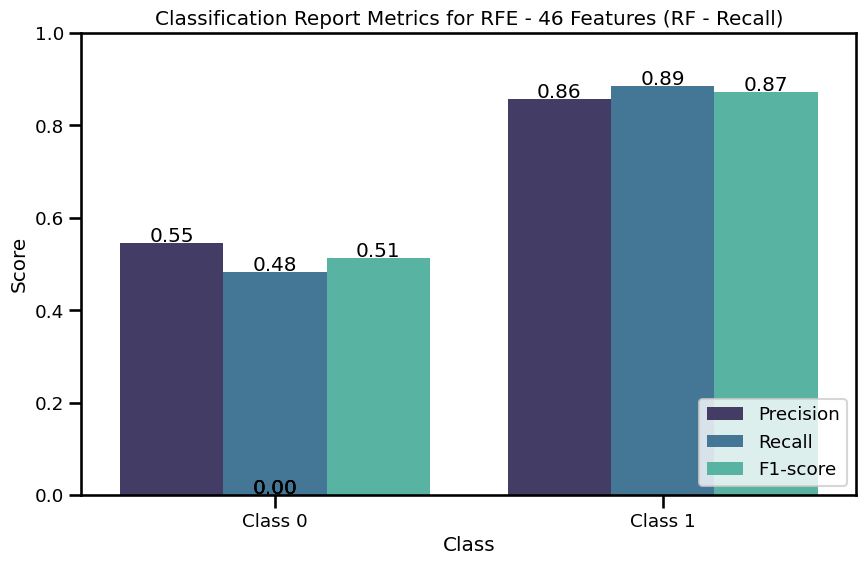

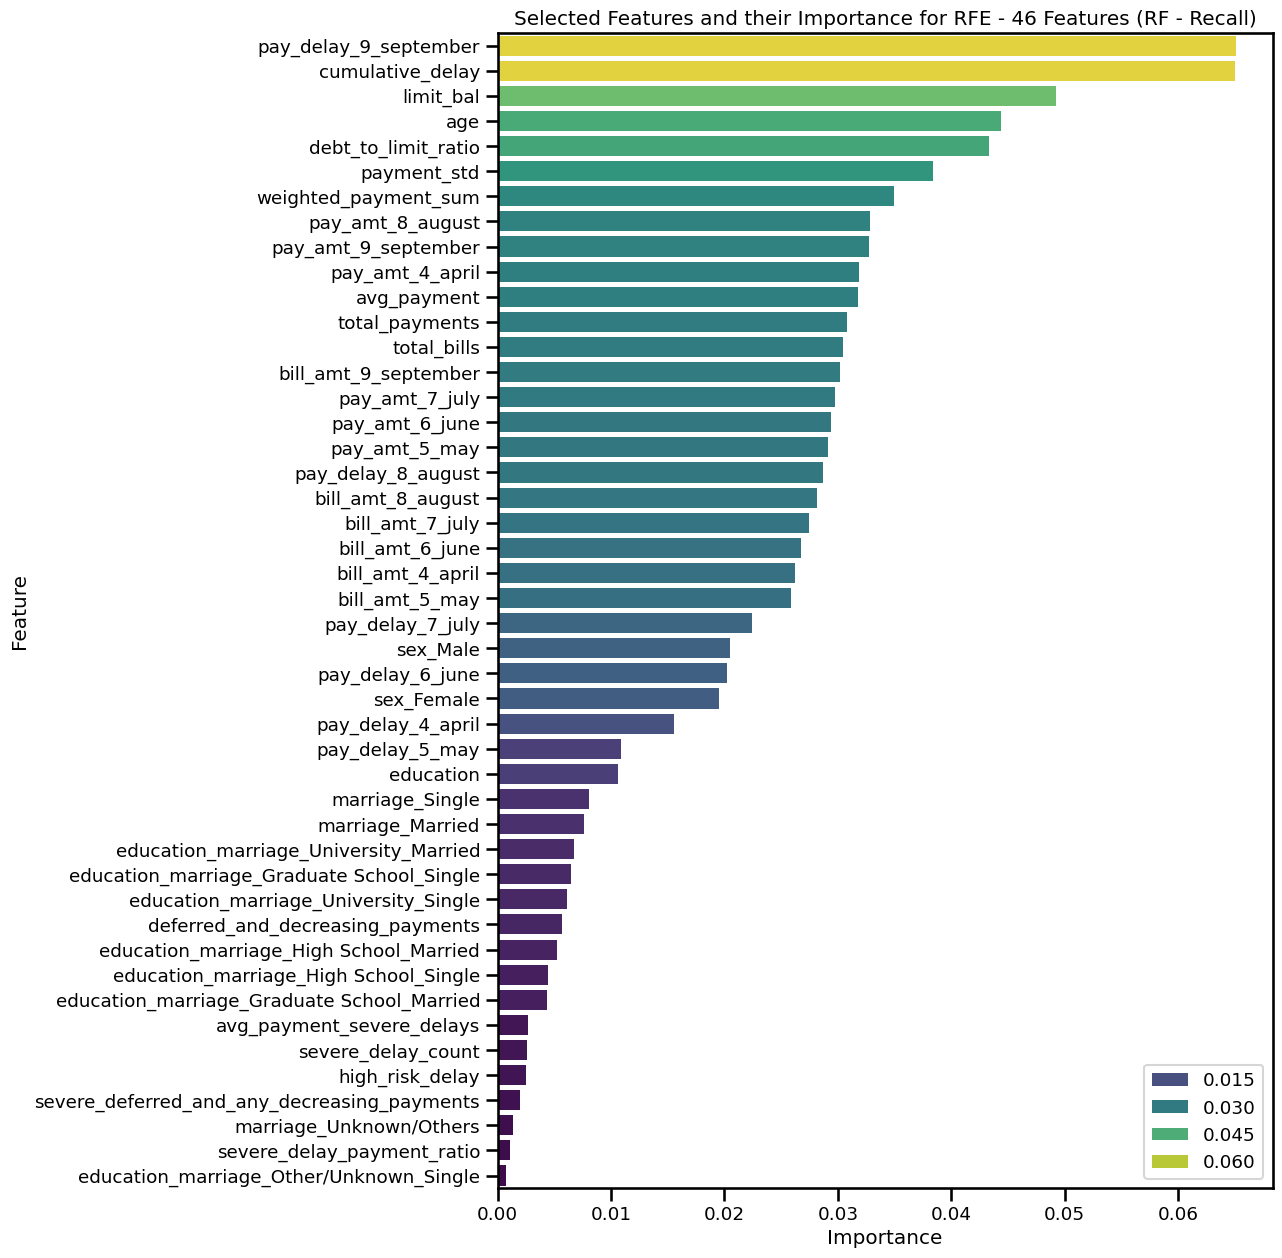

Classification Report (RFE - 11 Features (RF - Precision)):
              precision    recall  f1-score   support

           0       0.52      0.50      0.51      1326
           1       0.86      0.87      0.86      4667

    accuracy                           0.79      5993
   macro avg       0.69      0.68      0.69      5993
weighted avg       0.78      0.79      0.78      5993



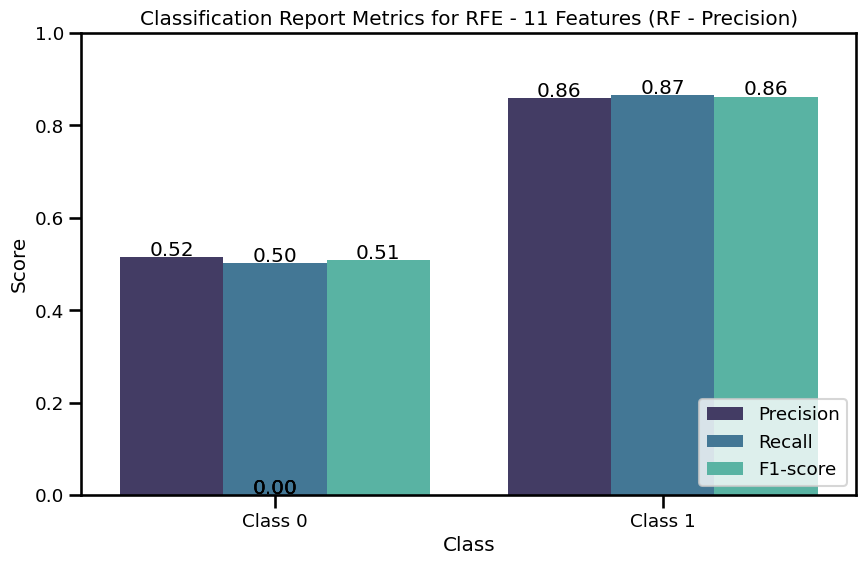

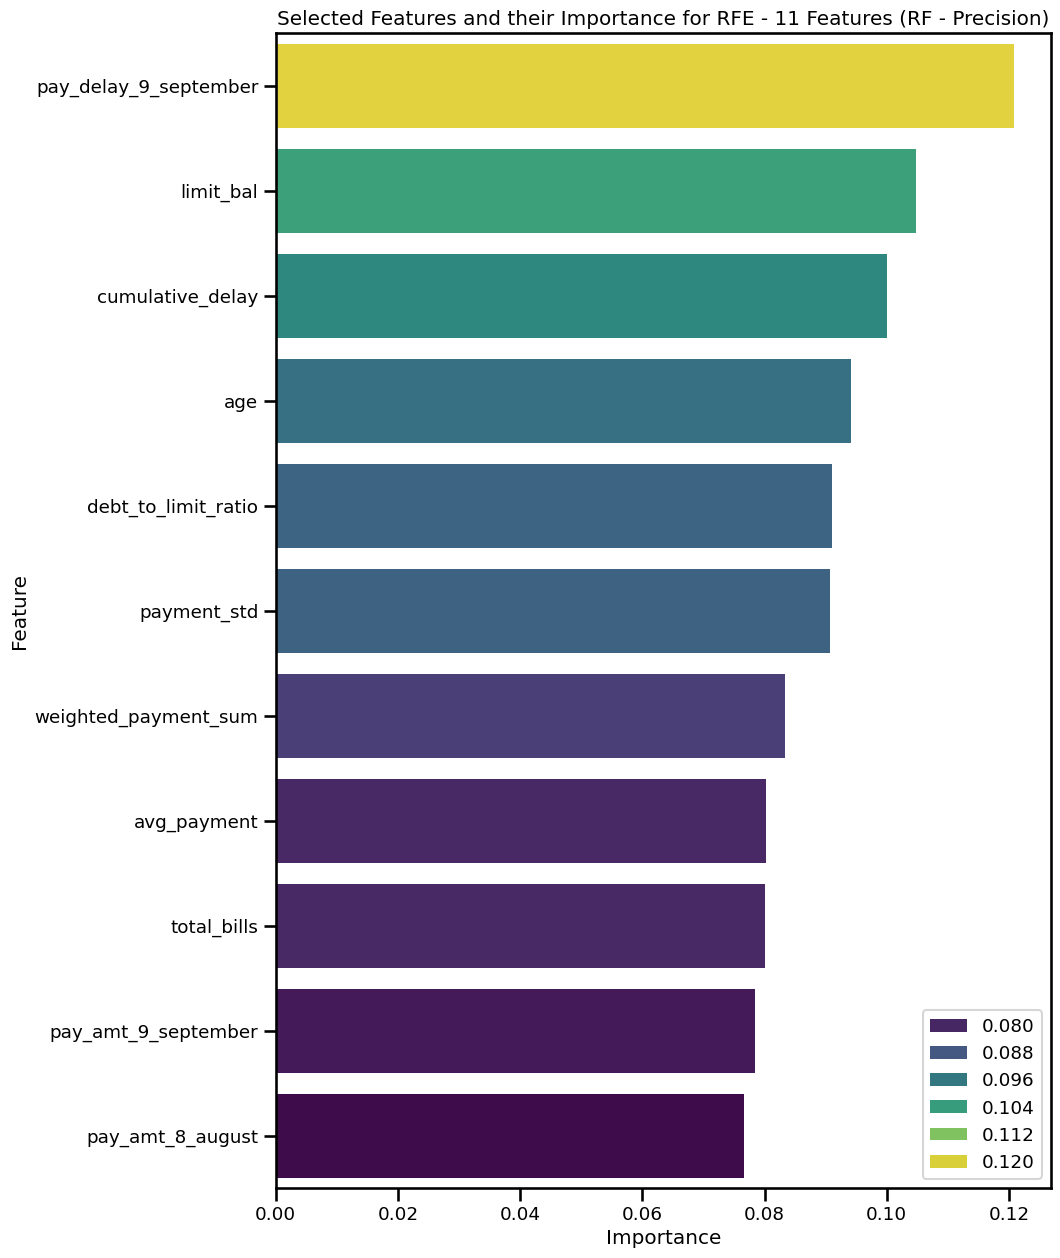

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
import json

# Step 1: Define the base classifier (Random Forest)
base_classifier = RandomForestClassifier(random_state=42)

# Function to run RFE with a specified number of features and return the feature importances
def run_rfe_and_get_importances(X_train, y_train, X_test, y_test, n_features, model_name):
    # Step 2: Define the RFE step with the base classifier and specified number of features
    rfe = RFE(estimator=base_classifier, n_features_to_select=n_features)

    # Step 3: Create the pipeline with feature selection and classification
    pipeline_rfe = Pipeline(steps=[
        ('feature_selection', rfe),
        ('classifier', base_classifier)
    ])

    # Step 4: Fit the pipeline to the training data
    pipeline_rfe.fit(X_train, y_train)

    # Step 5: Predict on the test data and generate the classification report
    y_pred_rfe = pipeline_rfe.predict(X_test)
    classification_report_rfe = classification_report(y_test, y_pred_rfe, output_dict=True)
    print(f"Classification Report ({model_name}):")
    print(classification_report(y_test, y_pred_rfe, output_dict=False))

    # Step 6: Extract the selected feature names and importances
    selected_binary_features_rfe = rfe.get_support()
    feature_names_rfe = X_train.columns.tolist()
    selected_feature_names_rfe = [feature_names_rfe[i] for i in range(len(feature_names_rfe)) if selected_binary_features_rfe[i]]

    # Extract feature importances for the selected features from the Random Forest
    feature_importances_rfe = rfe.estimator_.feature_importances_

    # Sort the selected features by their importance
    selected_features_rfe = dict(sorted(zip(selected_feature_names_rfe, feature_importances_rfe), key=lambda item: abs(item[1]), reverse=True))

    # Step 7: Plot the classification report metrics and selected features
    plot_classification_report_metrics(classification_report_rfe, model_name)
    plot_selected_features(selected_features_rfe, model_name, figsize=(10, 15))

    return classification_report_rfe, selected_features_rfe

# Step 8: Run RFE for recall-optimal (46 features) and precision-optimal (11 features)
classification_report_recall_optimal, selected_features_recall_optimal = run_rfe_and_get_importances(
    X_train_processed_df.drop(columns=['target']), y_train_resampled,
    X_test_processed_df.drop(columns=['target']), y_test,
    n_features=46,
    model_name='RFE - 46 Features (RF - Recall)'
)

classification_report_precision_optimal, selected_features_precision_optimal = run_rfe_and_get_importances(
    X_train_processed_df.drop(columns=['target']), y_train_resampled,
    X_test_processed_df.drop(columns=['target']), y_test,
    n_features=11,
    model_name='RFE - 11 Features (RF - Precision)'
)


## Recursive Feature Elimination with Cross-Validation (RFECV)
**Recursive Feature Elimination (RFE)** is a method that iteratively removes the least important features and re-trains the model, with the goal of finding the most significant subset of features. RFE starts with all features and removes them one by one, ranking features based on their importance (such as model coefficients for linear models or feature importance for tree-based models). After each iteration, the model is re-trained on the remaining features, and this continues until a specified number of features is reached.

**Recursive Feature Elimination with Cross-Validation (RFECV)** is an extension of RFE that incorporates cross-validation to optimize the feature selection process. Instead of specifying a fixed number of features to select, RFECV evaluates different subsets of features using cross-validation to find the optimal number of features. The goal is to choose the subset of features that gives the best performance (according to the chosen evaluation metric, like recall or precision) in a cross-validation setting. This ensures that the selected feature set generalizes better to unseen data.

### Key Differences:
- **RFE** requires a pre-defined number of features to select, whereas **RFECV** determines the optimal number of features using cross-validation.
- **RFECV** uses cross-validation to evaluate model performance on different subsets of features, making it more robust in selecting the optimal number of features compared to RFE, which might overfit without this validation.
- **RFECV** is computationally more expensive than RFE because of the added cross-validation step at each iteration of feature elimination.

In summary, **RFECV** is a more comprehensive and automated approach for feature selection, as it not only ranks features but also selects the optimal subset based on performance across cross-validation folds.

Classification Report (RFECV - Recall):
              precision    recall  f1-score   support

           0       0.54      0.49      0.51      1326
           1       0.86      0.88      0.87      4667

    accuracy                           0.79      5993
   macro avg       0.70      0.69      0.69      5993
weighted avg       0.79      0.79      0.79      5993



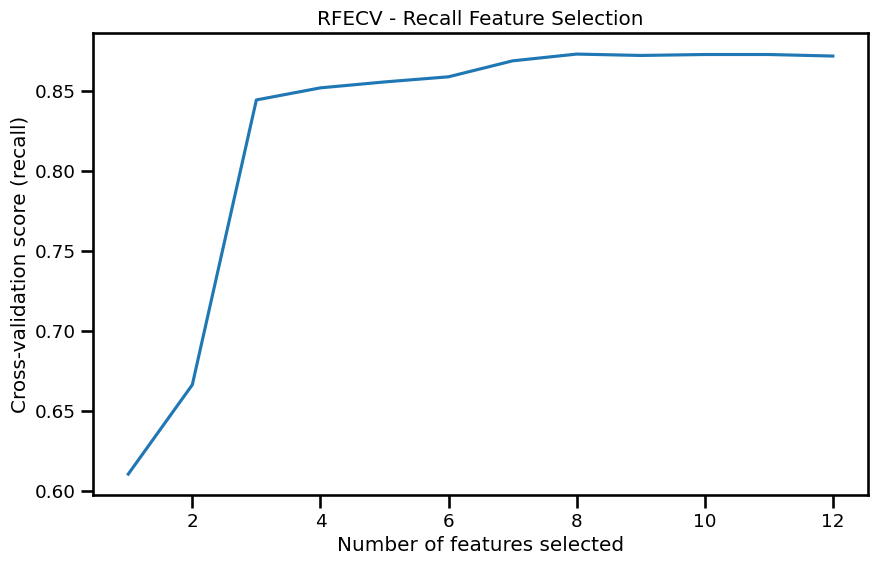

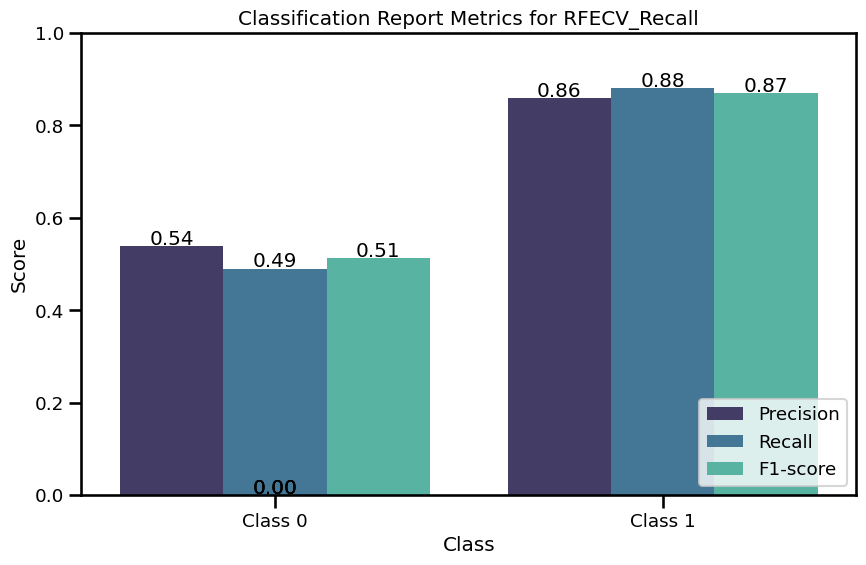

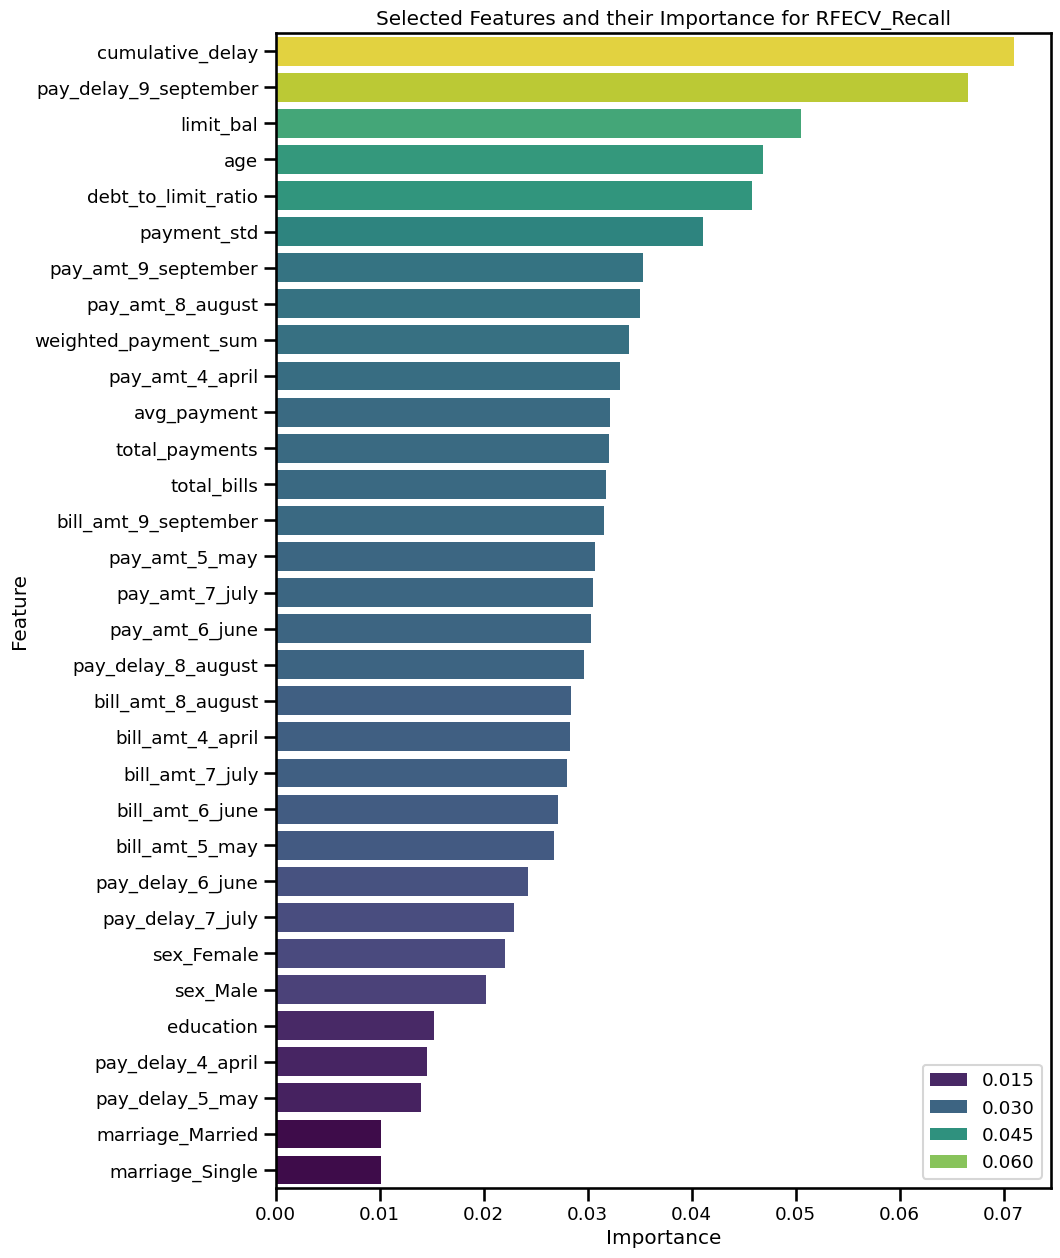

In [ ]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import json
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

# Scoring metric for feature selection
scoring = 'recall'

# Define the base model for RFECV (Random Forest)
base_model = RandomForestClassifier(random_state=42)

# Set up RFECV with a step size of 5 (removing 5 features at a time) with cross-validation
rfecv = RFECV(
    estimator=base_model,
    step=5,  # Change to remove 5 features at a time
    cv=StratifiedKFold(5),
    scoring=scoring,
    n_jobs=-1
)

# Define the pipeline
pipeline_rfecv = Pipeline(steps=[
    ('feature_selection', rfecv),  # RFECV for feature selection
    ('classifier', base_model)     # Random Forest classifier
])

# Train the model and perform feature selection using the processed training data
pipeline_rfecv.fit(X_train_processed_df.drop(columns=['target']), y_train_resampled)

# Evaluate on the test set using the processed test data
y_pred_rfecv = pipeline_rfecv.predict(X_test_processed_df.drop(columns=['target']))
print("Classification Report (RFECV - Recall):")
print(classification_report(y_test, y_pred_rfecv))
classification_report_rfecv = classification_report(y_test, y_pred_rfecv, output_dict=True)

# Extract the selected feature names
selected_binary_features_rfecv = rfecv.support_
feature_names_rfecv = X_train_processed_df.drop(columns=['target']).columns.tolist()
selected_feature_names_rfecv = [feature_names_rfecv[i] for i in range(len(feature_names_rfecv)) if selected_binary_features_rfecv[i]]

# Plot the number of features vs. cross-validation scores using cv_results_['mean_test_score']
plt.figure(figsize=(10, 6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross-validation score (recall)")
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'])
plt.title('RFECV - Recall Feature Selection')
plt.show()

# Save the classification report and selected features
with open('classification_reports_wrapper_methods_rf.json', 'r') as f:
    classification_reports = json.load(f)

with open('selected_features_wrapper_methods_rf.json', 'r') as f:
    selected_features = json.load(f)

classification_reports['RFECV_Recall'] = classification_report_rfecv
selected_features['RFECV_Recall'] = selected_feature_names_rfecv

# Save updated classification reports and selected features to JSON files
with open('classification_reports_wrapper_methods_rf.json', 'w') as f:
    json.dump(classification_reports, f, indent=4)

with open('selected_features_wrapper_methods_rf.json', 'w') as f:
    json.dump(selected_features, f, indent=4)

# Plot the classification report metrics and selected features
sorted_selected_features_rfecv = dict(sorted(zip(selected_feature_names_rfecv, rfecv.estimator_.feature_importances_), key=lambda item: abs(item[1]), reverse=True))
plot_classification_report_metrics(classification_report_rfecv, 'RFECV_Recall')
plot_selected_features(sorted_selected_features_rfecv, 'RFECV_Recall', figsize=(10, 15))


### Feature Engineering from Feature Importance Analysis
The interaction between **education** and **marriage** emerging as a top feature in terms of importance provides insight into a **relationship between these two factors** that is highly predictive. This suggests that certain combinations of education level and marital status may correlate strongly with the likelihood of the target outcome (e.g., loan default, financial risk, etc.). Based on this information, several additional features could be engineered to further explore and capture these relationships:

### 1. **Interaction with Income Level or Credit Limit**:
   - **Idea**: Create an interaction feature between **education, marriage**, and financial indicators like **income** or **credit limit**.
   - **Rationale**: This would capture how different education levels and marital statuses combined with financial capacity affect the likelihood of default.
   - **Example**:
     ```python
     df['edu_marriage_income_interaction'] = df['education'] * df['marriage'] * df['limit_bal']
     ```

### 2. **Combined Financial Responsibility (Joint Financial Risk)**:
   - **Idea**: Create a feature indicating whether individuals with certain marital statuses (e.g., married or divorced) and lower education levels are likely to experience financial strain.
   - **Rationale**: Lower education levels might be associated with lower income, and marital status could influence the shared financial burden, such as a single income in a household or potential child-related expenses.
   - **Example**:
     ```python
     df['joint_financial_risk'] = df.apply(lambda x: 1 if (x['marriage'] == 'Married' and x['education'] in ['High School', 'Other/Unknown']) else 0, axis=1)
     ```

### 3. **Household Financial Stress Indicator**:
   - **Idea**: Create a **binary indicator** for certain education-marriage combinations that typically correlate with high financial stress.
   - **Rationale**: Some combinations, like low education levels and single or divorced marital status, might imply higher financial stress. This feature would flag customers with potentially higher risk.
   - **Example**:
     ```python
     df['financial_stress_indicator'] = df.apply(lambda x: 1 if x['education'] == 'High School' and x['marriage'] in ['Single', 'Divorced'] else 0, axis=1)
     ```

### 4. **Interaction with Employment Status**:
   - **Idea**: Create an interaction feature between **education**, **marriage**, and **employment status** (if available).
   - **Rationale**: Employment status could further differentiate risk levels within the education-marriage groups, as someone with a lower education level but stable employment might be lower risk than someone unemployed or underemployed.
   - **Example**:
     ```python
     df['edu_marriage_employment'] = df['education'] * df['marriage'] * df['employment_status']  # Assuming 'employment_status' exists in the data
     ```

### 5. **Financial Independence Indicator**:
   - **Idea**: Develop an indicator that captures financial independence or dependence based on education and marital status.
   - **Rationale**: Married individuals with lower education levels might rely more on their spouse's income, whereas single or divorced individuals with higher education levels might be more financially independent, which could influence their risk.
   - **Example**:
     ```python
     df['financial_independence_indicator'] = df.apply(lambda x: 1 if (x['marriage'] in ['Single', 'Divorced'] and x['education'] in ['Graduate School', 'University']) else 0, axis=1)
     ```

### 6. **Educational Level and Household Size Interaction**:
   - **Idea**: If household size data is available, create an interaction feature between **education**, **marriage**, and **household size**.
   - **Rationale**: Larger household sizes combined with lower education levels may increase financial pressure, especially in single-income households.
   - **Example**:
     ```python
     df['edu_marriage_household_size_interaction'] = df['education'] * df['marriage'] * df['household_size']  # Assuming 'household_size' exists in the data
     ```

### 7. **Risk Groups Based on Education-Marriage Clusters**:
   - **Idea**: Use the combinations of **education** and **marriage** to create categorical risk groups (e.g., high, medium, low risk).
   - **Rationale**: By clustering different education-marriage combinations based on risk levels seen in the model, we can create groups that simplify the analysis of default likelihood.
   - **Example**:
     ```python
     df['education_marriage_risk_group'] = df.apply(lambda x: 'High' if (x['education'] == 'High School' and x['marriage'] == 'Single') else 'Low', axis=1)
     ```

### 8. **Interaction with Payment Behavior**:
   - **Idea**: Combine **education, marriage**, and recent **payment behavior** (e.g., number of late payments, average payment amount).
   - **Rationale**: Education and marriage status may influence how individuals handle their financial obligations, especially in times of financial strain.
   - **Example**:
     ```python
     df['edu_marriage_pay_behavior'] = df['education'] * df['marriage'] * df['avg_payment']
     ```

### 9. **Regional or Cultural Impact (if available)**:
   - **Idea**: If the data includes **region** or **cultural background**, create an interaction feature between **education**, **marriage**, and **region**.
   - **Rationale**: The interaction between education and marriage may have different impacts on financial behavior in different regions or cultures.
   - **Example**:
     ```python
     df['edu_marriage_region_interaction'] = df['education'] * df['marriage'] * df['region']  # Assuming 'region' exists in the data
     ```

### Conclusion:
By building these interaction features, you can potentially capture more nuanced relationships between education, marital status, and other financial behaviors. The combination of education and marriage status can reflect societal roles and economic responsibilities, and these engineered features could significantly enhance model performance by addressing these complex interactions.

#### Loan Data Utils

In [ ]:
script_content=r'''
# loan_data_utils.py

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import logging
from sklearn.metrics import classification_report
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin

import json

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

target = 'default_payment_next_month'
# Define primary, bill, and pay columns
primary_columns = ['limit_bal', 'sex', 'education', 'marriage', 'age']
bill_columns = ['bill_amt_4_april', 'bill_amt_5_may', 'bill_amt_6_june', 'bill_amt_7_july', 'bill_amt_8_august', 'bill_amt_9_september']
pay_columns = ['pay_amt_4_april', 'pay_amt_5_may', 'pay_amt_6_june', 'pay_amt_7_july', 'pay_amt_8_august', 'pay_amt_9_september']
ordinal_columns = ['education', 'pay_delay_9_september', 'pay_delay_8_august', 'pay_delay_7_july', 'pay_delay_6_june', 'pay_delay_5_may', 'pay_delay_4_april']

def load_data_from_url(url):
    try:
        df = pd.read_excel(url, header=1)
        logging.info("Data loaded successfully from URL.")
    except Exception as e:
        logging.error(f"Error loading data from URL: {e}")
        return None
    return df

def split_features_target(df, target):
    try:
        X = df.drop(columns=[target])
        y = df[target]
        logging.info("Features and target split successfully.")
    except Exception as e:
        logging.error(f"Error splitting features and target: {e}")
        return None, None
    return X, y


def clean_column_names(df):
    try:
        df.columns = [col.lower().replace(' ', '_') for col in df.columns]
        logging.info("Column names cleaned successfully.")
    except Exception as e:
        logging.error(f"Error cleaning column names: {e}")
    return df

def remove_id_column(df):
    if 'id' in df.columns:
        df = df.drop(columns=['id'])
        logging.info("ID column removed.")
    return df

# ---------  Sex Column Processing  --------- #
# ---- SEX: Gender (1 = male, 2 = female) ----#

# results in cat.categories = ['Female', 'Male'][0,1]
def process_sex_column(df):
    try:
        if 'sex' in df.columns:
            df['sex'] = df['sex'].replace({1: 'Male', 2: 'Female'})
            df['sex'] = df['sex'].astype('category')
            logging.info("Sex column processed and converted to categorical successfully.")
        else:
            logging.warning("Sex column not found in DataFrame.")
    except Exception as e:
        logging.error(f"Error processing sex column: {e}")
    return df

# results in cat.categories = ['Female', 'Male'][2,1] (alphabetically ordered)
def process_sex_column_cat_codes_one_two(df):
    try:
        if 'sex' in df.columns:
            # Convert numeric values to categorical, maintaining original codes
            df['sex'] = df['sex'].astype('category')  # First, ensure the column is categorical

            # Define the categories explicitly and map original values (1: Male, 2: Female)
            df['sex'].cat.set_categories([1, 2], rename=True, inplace=True)  # Set categories as 1, 2
            df['sex'] = df['sex'].replace({1: 'Male', 2: 'Female'})  # Replace numeric values with labels

            logging.info("Sex column processed and converted to categorical successfully.")
        else:
            logging.warning("Sex column not found in DataFrame.")
    except Exception as e:
        logging.error(f"Error processing sex column: {e}")
    return df

# ---------  Marriage Column Processing  --------- #

# ---- MARRIAGE: Marital status (1 = married, 2 = single, 3 = other) ----#

def process_marriage_column(df):
    try:
        if 'marriage' in df.columns:
            df['marriage'] = df['marriage'].replace({0: 'Unknown/Others', 3: 'Unknown/Others'})
            df['marriage'] = df['marriage'].replace({1: 'Married', 2: 'Single'})
            df['marriage'] = pd.Categorical(df['marriage'], categories=['Married', 'Single', 'Unknown/Others'], ordered=False)
            logging.info("Marriage column processed and converted to categorical successfully.")
        else:
            logging.warning("Marriage column not found in DataFrame.")
    except Exception as e:
        logging.error(f"Error processing marriage column: {e}")
    return df

# ---------  Target Column Processing  --------- #

def process_default_payment_column(df):
    try:
        if 'default_payment_next_month' in df.columns:
            # Convert 0 and 1 to categorical values
            df['default_payment_next_month'] = df['default_payment_next_month'].astype('category')
            logging.info("Default payment column processed and converted to categorical successfully.")
        else:
            logging.warning("Default payment column not found in DataFrame.")
    except Exception as e:
        logging.error(f"Error processing default payment column: {e}")
    return df

# convert category labels for EDA
def process_default_payment_column(df):
    try:
        if 'default_payment_next_month' in df.columns:
            # Label the categories
            df['default_payment_next_month'] = df['default_payment_next_month'].replace({0: 'No Default', 1: 'Default'})
            df['default_payment_next_month'] = df['default_payment_next_month'].astype('category')
            logging.info("Default payment column labeled and converted to categorical successfully.")
        else:
            logging.warning("Default payment column not found in DataFrame.")
    except Exception as e:
        logging.error(f"Error processing default payment column: {e}")
    return df

# Convert labels to numeric for modeling
def convert_default_payment_to_numeric(df):
    try:
        if 'default_payment_next_month' in df.columns:
            df['default_payment_next_month'] = df['default_payment_next_month'].replace({'No Default': 0, 'Default': 1}).astype(int)
            logging.info("Default payment column converted back to numeric for modeling.")
        else:
            logging.warning("Default payment column not found in DataFrame.")
    except Exception as e:
        logging.error(f"Error converting default payment column to numeric: {e}")
    return df

# ---------  Pay Delay Column Processing  --------- #

def rename_pay_columns(df):
    try:
        # Only rename if the original columns exist
        if all(col in df.columns for col in ['pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']):
            pay_columns_new_names = {
                'pay_0': 'pay_delay_9_september',
                'pay_2': 'pay_delay_8_august',
                'pay_3': 'pay_delay_7_july',
                'pay_4': 'pay_delay_6_june',
                'pay_5': 'pay_delay_5_may',
                'pay_6': 'pay_delay_4_april'
            }
            df = df.rename(columns=pay_columns_new_names)
            logging.info("Pay delay columns renamed successfully.")
        else:
            logging.warning("Some or all of the expected pay columns are missing. Renaming skipped.")
    except Exception as e:
        logging.error(f"Error renaming pay delay columns: {e}")
    return df

def rename_bill_and_payment_columns(df):
    try:
        # Correct renaming of bill_amt and pay_amt columns
        bill_amt_new_names = {
            'bill_amt1': 'bill_amt_9_september',
            'bill_amt2': 'bill_amt_8_august',
            'bill_amt3': 'bill_amt_7_july',
            'bill_amt4': 'bill_amt_6_june',
            'bill_amt5': 'bill_amt_5_may',
            'bill_amt6': 'bill_amt_4_april'
        }

        pay_amt_new_names = {
            'pay_amt1': 'pay_amt_9_september',
            'pay_amt2': 'pay_amt_8_august',
            'pay_amt3': 'pay_amt_7_july',
            'pay_amt4': 'pay_amt_6_june',
            'pay_amt5': 'pay_amt_5_may',
            'pay_amt6': 'pay_amt_4_april'
        }

        df = df.rename(columns={**bill_amt_new_names, **pay_amt_new_names})
        logging.info("Bill and payment columns renamed successfully.")
    except Exception as e:
        logging.error(f"Error renaming bill and payment columns: {e}")
    return df


def label_pay_columns(df, pay_columns):
    try:
        # Only label the pay_delay_* columns, not pay_amt_*
        pay_labels = {
            -2: "No consumption",
            -1: "Paid in full",
            0: "Revolving credit",
            1: "1 month delay",
            2: "2 months delay",
            3: "3 months delay",
            4: "4 months delay",
            5: "5 months delay",
            6: "6 months delay",
            7: "7 months delay",
            8: "8 months delay",
            9: "9+ months delay"
        }

        for col in pay_columns:
            # Ensure we're only mapping the delay columns and not payment amount columns
            if 'pay_delay' in col and col in df.columns:
                df[col] = df[col].map(pay_labels)
                logging.info(f"Column {col} labeled successfully.")
            else:
                logging.error(f"Column {col} not found in DataFrame.")

    except Exception as e:
        logging.error(f"Error labeling pay columns: {e}")
    return df

def convert_pay_columns_to_ordinal(df, pay_columns):
    try:
        pay_order = [
            "No consumption",  # -2
            "Paid in full",    # -1
            "Revolving credit", # 0
            "1 month delay",   # 1
            "2 months delay",  # 2
            "3 months delay",  # 3
            "4 months delay",  # 4
            "5 months delay",  # 5
            "6 months delay",  # 6
            "7 months delay",  # 7
            "8 months delay",  # 8
            "9+ months delay"  # 9
        ]

        for col in pay_columns:
            # Ensure only delay columns are converted to categorical
            if 'pay_delay' in col and col in df.columns:
                df[col] = pd.Categorical(df[col], categories=pay_order, ordered=True)
                logging.info(f"Column {col} converted to ordinal successfully.")
            else:
                logging.error(f"Column {col} not found in DataFrame.")

    except Exception as e:
        logging.error(f"Error converting pay columns to ordinal categories: {e}")
    return df


def convert_ordinal_to_category(df, ordinal_columns):
    try:
        for col in ordinal_columns:
            if col in df.columns:
                df[col] = df[col].astype('category')
                logging.info(f"Column {col} converted to category successfully.")
            else:
                logging.error(f"Column {col} not found in DataFrame.")
    except Exception as e:
        logging.error(f"Error converting ordinal columns to category: {e}")
    return df

# ---------  Education Column Processing  --------- #

def convert_education_to_ordinal(df):
    try:
        # Explicitly map all values to handle known categories
        education_mapping = {
            1: 'Graduate School',
            2: 'University',
            3: 'High School',
            4: 'Other/Unknown',
            5: 'Other/Unknown',
            6: 'Other/Unknown',
            0: 'Other/Unknown'  # Handle the 0 value as well
        }

        df['education'] = df['education'].replace(education_mapping)

        # Define the order of education categories
        education_order = [
            "Other/Unknown",    # Grouped 0, 4, 5, 6 together
            "High School",      # 3
            "University",       # 2
            "Graduate School"   # 1
        ]

        if 'education' in df.columns:
            # Convert the education column to a categorical type with the specified order
            df['education'] = pd.Categorical(df['education'], categories=education_order, ordered=True)
            logging.info("Education column converted to ordinal categories successfully.")
        else:
            logging.error("Education column not found in DataFrame.")
    except Exception as e:
        logging.error(f"Error converting education column to ordinal categories: {e}")
    return df


#-------- Utility and validation functions first ----------#

def check_column_integrity(df, expected_columns):
    missing_columns = [col for col in expected_columns if col not in df.columns]
    if missing_columns:
        logging.error(f"Missing columns: {missing_columns}")
    else:
        logging.info("All expected columns are present.")

def validate_data_types(df, ordinal_columns):
    for col in ordinal_columns:
        if col in df.columns:
            if not pd.api.types.is_categorical_dtype(df[col]):
                logging.warning(f"Column {col} is not correctly set as categorical.")
            else:
                logging.info(f"Column {col} is correctly set as categorical with the following categories: {df[col].cat.categories}")
        else:
            logging.error(f"Column {col} not found in DataFrame.")
    logging.info("Data type validation complete.")

def reorder_columns(df):
    try:
        # Define the order of the pay_delay columns in chronological order
        pay_delay_order = [
            'pay_delay_4_april',
            'pay_delay_5_may',
            'pay_delay_6_june',
            'pay_delay_7_july',
            'pay_delay_8_august',
            'pay_delay_9_september'
        ]

        # Combine primary, bill, pay, and pay_delay columns with other columns
        other_columns = [col for col in df.columns if col not in primary_columns + bill_columns + pay_columns + pay_delay_order]
        df = df[primary_columns + bill_columns + pay_columns + pay_delay_order + other_columns]
        logging.info("Columns reordered successfully.")
    except Exception as e:
        logging.error(f"Error reordering columns: {e}")
    return df


#--------  Load and Preprocess Data  --------- #

def load_and_preprocess_data(url, categorical_columns, target):
    df = load_data_from_url(url)
    if df is not None:
        try:
            # Include the target column from the start
            df = clean_column_names(df)
            df = remove_id_column(df)
            df = rename_pay_columns(df)
            df = rename_bill_and_payment_columns(df)
            df = label_pay_columns(df, [col for col in df.columns if 'pay_delay' in col])
            df = convert_pay_columns_to_ordinal(df, [col for col in df.columns if 'pay_delay' in col])
            df = reorder_columns(df)
            df = convert_education_to_ordinal(df)
            df = process_sex_column(df)
            # df = process_sex_column_cat_codes_one_two(df)
            df = process_marriage_column(df)
            df = process_default_payment_column(df)
            df = convert_ordinal_to_category(df, ordinal_columns)

            # Run validation checks
            check_column_integrity(df, primary_columns + bill_columns + pay_columns + ordinal_columns)
            validate_data_types(df, ordinal_columns)

            # Drop duplicates consistently across both features and target
            df = df.drop_duplicates()

            logging.info("Data loaded and preprocessed successfully.")
            return df
        except Exception as e:
            logging.error(f"Error in data preprocessing: {e}")
            return None
    return None

#--------  Load Preprocess Split Data  --------- #

def load_preprocess_split_data(url, categorical_columns, target):
    df = load_data_from_url(url)
    if df is not None:
        try:
            df = clean_column_names(df)
            df = remove_id_column(df)
            df = rename_pay_columns(df)
            df = rename_bill_and_payment_columns(df)
            df = label_pay_columns(df, [col for col in df.columns if 'pay_delay' in col])
            df = convert_pay_columns_to_ordinal(df, [col for col in df.columns if 'pay_delay' in col])
            df = reorder_columns(df)
            df = convert_education_to_ordinal(df)
            df = process_sex_column(df)  # Process the sex column separately
            df = process_marriage_column(df)  # Process the marriage column separately
            df = convert_ordinal_to_category(df, ordinal_columns)

            # Run validation checks
            check_column_integrity(df, primary_columns + bill_columns + pay_columns + ordinal_columns)
            validate_data_types(df, ordinal_columns)

            X, y = split_features_target(df, target)
            logging.info("Data loaded and preprocessed successfully.")
            return X, y
        except Exception as e:
            logging.error(f"Error in data preprocessing: {e}")
            return None, None
    return None, None


def check_categorical_order(df, columns):
    for col in columns:
        if pd.api.types.is_categorical_dtype(df[col]):
            print(f"Column: {col}")
            print(f"Categories: {df[col].cat.categories}")
            print(f"Ordered: {df[col].cat.ordered}\n")
        else:
            print(f"Column: {col} is not categorical.\n")

#--------  Plot Categorical Data Functions  --------- #

categorical_columns = [
    'default_payment_next_month', 'sex', 'education', 'marriage'
]

ordinal_columns = [
    'pay_delay_4_april', 'pay_delay_5_may', 'pay_delay_6_june',
    'pay_delay_7_july', 'pay_delay_8_august', 'pay_delay_9_september'
]

def plot_categorical_distributions(df, categorical_columns):
    """Function to plot categorical distributions."""
    plt.figure(figsize=(16, 14))
    sns.set_context('talk')
    for i, column in enumerate(categorical_columns, 1):
        plt.subplot(2, 2, i)
        sns.countplot(data=df, x=column, hue=column, palette='Set3', legend=False)
        plt.title(f'Distribution of {column}')
        plt.xlabel(column)
        plt.ylabel('Count')

        # Add percentage annotations
        total = len(df)
        for p in plt.gca().patches:
            percentage = 100 * p.get_height() / total
            plt.gca().text(p.get_x() + p.get_width() / 2, p.get_height(),
                           f'{percentage:.1f}%', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()


def plot_ordinal_distributions(df, ordinal_columns):
    """Function to plot ordinal distributions using barplot with hue."""
    plt.figure(figsize=(16, 25))
    sns.set_context('talk', font_scale=0.8)
    for i, column in enumerate(ordinal_columns, 1):
        plt.subplot(3, 2, i)

        # Get the counts for each category
        category_counts = df[column].value_counts().sort_index()

        sns.barplot(x=category_counts.index, y=category_counts.values, hue=category_counts.index, palette='Set3')

        plt.title(f'Distribution of {column}')
        plt.xlabel(column)
        plt.ylabel('Count')

        # Rotate x-tick labels for better legibility
        plt.xticks(rotation=45, ha='right')

        # Add percentage annotations
        total = len(df)
        for p in plt.gca().patches:
            percentage = 100 * p.get_height() / total
            plt.gca().text(p.get_x() + p.get_width() / 2, p.get_height(),
                           f'{percentage:.1f}%', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()


# --------- Custom Transformer for Threshold Classifier --------- #

class ThresholdClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, base_classifier=None, threshold=0.5):
        # Default to LogisticRegression if no classifier is provided
        self.base_classifier = base_classifier if base_classifier is not None else LogisticRegression(max_iter=1000)
        self.threshold = threshold

    def fit(self, X, y):
        # Fit the base classifier on the training data
        self.base_classifier.fit(X, y)
        return self

    def predict(self, X):
        # Get the predicted probabilities for class 1 (positive class)
        probas = self.base_classifier.predict_proba(X)[:, 1]
        # Apply the threshold to make class predictions
        return (probas >= self.threshold).astype(int)

    def predict_proba(self, X):
        # Return the predicted probabilities from the base classifier
        return self.base_classifier.predict_proba(X)


#--------  Classification Report Functions  --------- #

# Function to save the classification reports to a JSON file
def save_classification_reports(reports, filename='classification_reports.json'):
    with open(filename, 'w') as json_file:
        json.dump(reports, json_file, indent=4)  # Use indent for pretty-printing
    print(f"Classification reports saved as {filename}")


# Plotting function with annotations
def plot_classification_report_metrics(report, model_name):
    metrics_df = pd.DataFrame({
        'Class': ['Class 0', 'Class 0', 'Class 0', 'Class 1', 'Class 1', 'Class 1'],
        'Metric': ['Precision', 'Recall', 'F1-score', 'Precision', 'Recall', 'F1-score'],
        'Value': [
            report['0']['precision'],
            report['0']['recall'],
            report['0']['f1-score'],
            report['1']['precision'],
            report['1']['recall'],
            report['1']['f1-score']
        ]
    })

    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x='Class', y='Value', hue='Metric', data=metrics_df, palette='mako')
    plt.title(f'Classification Report Metrics for {model_name}')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.legend(loc='lower right')

    # Annotate the bars with the values
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height:.2f}',
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='center',
                    xytext=(0, 5),
                    textcoords='offset points')

    plt.show()

#--------  Classification Report Functions for Categories  --------- #

# Function to save classification reports with custom categories
def save_classification_reports_with_categories(reports, filename='classification_reports.json'):
    try:
        # Adjust the keys for the class labels to match your custom categories
        for model, report in reports.items():
            if '0' in report and '1' in report:
                report['No Default'] = report.pop('0')
                report['Default'] = report.pop('1')

        with open(filename, 'w') as json_file:
            json.dump(reports, json_file, indent=4)  # Pretty-printing for clarity
        print(f"Classification reports with categories saved as {filename}")
    except Exception as e:
        print(f"Error saving classification reports: {e}")

# Updated plotting function with category names and annotations
def plot_classification_report_metrics_with_categories(report, model_name):
    metrics_df = pd.DataFrame({
        'Class': ['No Default', 'No Default', 'No Default', 'Default', 'Default', 'Default'],
        'Metric': ['Precision', 'Recall', 'F1-score', 'Precision', 'Recall', 'F1-score'],
        'Value': [
            report['No Default']['precision'],
            report['No Default']['recall'],
            report['No Default']['f1-score'],
            report['Default']['precision'],
            report['Default']['recall'],
            report['Default']['f1-score']
        ]
    })

    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x='Class', y='Value', hue='Metric', data=metrics_df, palette='mako')
    plt.title(f'Classification Report Metrics for {model_name}')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.legend(loc='lower right')

    # Annotate the bars with the values
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height:.2f}',
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='center',
                    xytext=(0, 5),
                    textcoords='offset points')

    plt.show()

#--------   Plot Selected Features  --------#

def plot_selected_features(selected_features, model_name, figsize=(16,8)):
    features = list(selected_features.keys())
    importances = list(selected_features.values())
    plt.figure(figsize=figsize)
    sns.barplot(x=importances, y=features, hue=importances, palette='viridis')
    plt.title(f'Selected Features and their Importance for {model_name}')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()
'''

# Write the script to a file
with open("loan_data_utils.py", "w") as file:
    file.write(script_content)

print("Script successfully written to loan_data_utils.py")
# Reload script to make functions available for use
import importlib
import loan_data_utils
importlib.reload(loan_data_utils)

from loan_data_utils import *


Script successfully written to loan_data_utils.py


#### EDA Utils

In [ ]:
script_content=r'''
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#--------   Data Overview   --------#

def data_overview(X):
    # Calculate missing values and their percentage
    missing_values = X.isnull().sum().sum()
    missing_percentage = (missing_values / len(X)) * 100

    # Calculate the number of duplicate rows
    duplicate_rows = X.duplicated().sum()

    # Print missing values, missing percentage, and duplicate information
    print("Missing Values:", missing_values)
    print("Missing Percentage:", missing_percentage)
    print(f"Number of Duplicate Rows: {duplicate_rows}\n")

    # Print basic information
    X.info()

#--------   Plot Class Distribution   --------#

def plot_class_distribution(y_train, target_name):
    sns.set()
    sns.set(style="ticks")
    sns.set_context('notebook')
    plt.figure(figsize=(8, 5))
    sns.countplot(x=y_train, hue=y_train, palette='viridis')
    plt.title(f'Class Distribution in Training Set: {target_name}')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.legend([], [], frameon=False)

    # Calculate the percentage for each class
    total = len(y_train)
    class_counts = y_train.value_counts()
    for i, count in enumerate(class_counts):
        percentage = 100 * count / total
        plt.text(i, count, f'{percentage:.1f}%', ha='center', va='bottom')

    plt.show()

#--------   Plot Univariate Distributions   --------#

def plot_univariate_distributions(X, categorical_columns):
    numeric_columns = X.select_dtypes(include=[np.number]).columns
    sns.set(style="ticks")
    sns.set_context('talk')

    # Plot histograms and KDE plots for numeric features
    for col in numeric_columns:
        plt.figure(figsize=(14, 5))

        # Histogram and KDE plot
        plt.subplot(1, 2, 1)
        sns.histplot(X[col], kde=True, color='forestgreen')
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)

        # Boxplot to detect outliers
        plt.subplot(1, 2, 2)
        sns.boxplot(x=X[col], color='limegreen')
        plt.title(f'Boxplot of {col}')
        plt.xlabel(col)

        plt.tight_layout()
        plt.show()

    # Plot bar plots for other categorical features
    for col in categorical_columns:
        plt.figure(figsize=(8, 5))
        sns.countplot(x=X[col], hue=X[col], palette='viridis')
        plt.title(f'Category Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Count')
        plt.show()

def plot_pay_delay_distributions(X, pay_delay_columns, aggregate_threshold=10):
    sns.set(style="ticks")
    sns.set_context('talk')

    for col in pay_delay_columns:
        # Aggregate categories with low counts into a single "Other" category
        value_counts = X[col].value_counts()
        low_count_categories = value_counts[value_counts < aggregate_threshold].index
        X[col] = X[col].apply(lambda x: 'Other' if x in low_count_categories else x)

        plt.figure(figsize=(10, 5))

        # Count plot for pay_delay columns
        sns.countplot(x=X[col], hue=X[col], palette='viridis', order=value_counts.index)
        plt.title(f'Distribution of {col.replace("_", " ").title()} (Aggregated)')
        plt.xlabel(col)
        plt.ylabel('Count')

        # Rotate the x-axis labels for better visibility
        plt.xticks(rotation=45)
        plt.show()

'''

# Write the script to a file
with open("eda_utils.py", "w") as file:
    file.write(script_content)

print("Script successfully written to eda_utils.py")
# Reload script to make functions available for use
import importlib
import eda_utils
importlib.reload(eda_utils)

from eda_utils import *

Script successfully written to eda_utils.py


#### Data Transform Utils

In [ ]:
script_content=r'''

# data_transformations_utils.py

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mstats
from sklearn.preprocessing import RobustScaler, PowerTransformer, QuantileTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import json
import logging

# Function to evaluate the baseline model
def evaluate_baseline_model(preprocessor, X_train, X_test, y_train, y_test):
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(max_iter=1000, random_state=42))
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    return report

# Function to apply Winsorization (Capping)
def winsorize_transform(X):
    X_transformed = X.copy()
    for col in X_transformed.columns:
        X_transformed[col] = mstats.winsorize(X_transformed[col], limits=[0.05, 0.05])
    return X_transformed

# Function to apply the Combined Method: IQR + Winsorization + Robust Scaling
def combined_outlier_removal(X):
    # Step 1: Apply IQR method to remove outliers
    def apply_iqr_outlier_removal(df):
        df_cleaned = df.copy()
        for col in df_cleaned.columns:
            Q1 = df_cleaned[col].quantile(0.25)
            Q3 = df_cleaned[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            df_cleaned = df_cleaned[(df_cleaned[col] >= lower_bound) & (df_cleaned[col] <= upper_bound)]
        return df_cleaned

    # Step 2: Apply Winsorization to cap extreme values
    def apply_winsorization(df):
        df_winsorized = df.copy()
        for col in df_winsorized.columns:
            df_winsorized[col] = mstats.winsorize(df_winsorized[col], limits=[0.05, 0.05])
        return df_winsorized

    # Step 3: Apply RobustScaler to normalize the data
    def apply_robust_scaler(df):
        scaler = RobustScaler()
        return pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

    # Apply all the steps in sequence
    X_cleaned = apply_iqr_outlier_removal(X)
    X_winsorized = apply_winsorization(X_cleaned)
    X_scaled = apply_robust_scaler(X_winsorized)

    return X_scaled


# Function to create the preprocessing pipeline
def create_preprocessor(ordinal_columns, categorical_columns, numeric_columns, categories_for_encoder):
    preprocessor = ColumnTransformer(
        transformers=[
            ('ordinal', Pipeline([
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('encoder', OrdinalEncoder(categories=categories_for_encoder))
            ]), ordinal_columns),

            ('categorical', Pipeline([
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))
            ]), categorical_columns),

            ('numeric', Pipeline([
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler())
            ]), numeric_columns)
        ],
        remainder='passthrough'
    )
    return preprocessor

# Function to evaluate models with different transformations
def evaluate_method(preprocessor, X_train, X_test, y_train, y_test, method_name, classification_reports, pay_columns, transformation):
    logging.info(f"Evaluating method: {method_name}")

    # Apply the transformation only to the specified pay_columns
    transformed_train = transformation(X_train[pay_columns])
    transformed_test = transformation(X_test[pay_columns])

    # Replace the original pay columns with the transformed data
    X_train_transformed = X_train.copy()
    X_test_transformed = X_test.copy()
    X_train_transformed[pay_columns] = transformed_train
    X_test_transformed[pay_columns] = transformed_test

    # Build the pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(max_iter=1000, random_state=42))
    ])

    # Train and evaluate the model
    pipeline.fit(X_train_transformed, y_train)
    y_pred = pipeline.predict(X_test_transformed)
    report = classification_report(y_test, y_pred, output_dict=True)

    # Save the report in the dictionary under the method name
    classification_reports[method_name] = report

# Log transformation function for pay columns
def log_transform(X, pay_columns):
    X_transformed = X.copy()
    for col in pay_columns:
        # Apply log1p transformation and handle any potential NaN/Inf values
        X_transformed[col] = np.log1p(X_transformed[col].replace([np.inf, -np.inf], np.nan)).fillna(0)
    return X_transformed[pay_columns]

'''

with open('data_transformations_utils.py', 'w') as file:
    file.write(script_content)

print("data_transformations_utils.py created successfully")
# Reload script to make functions available for use
import importlib
import data_transformations_utils
importlib.reload(data_transformations_utils)

from data_transformations_utils import *


data_transformations_utils.py created successfully


#### Feature Engineering Pipeline Script

In [ ]:
script_content = r'''
# feature_engineering_pipeline_utils.py

from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import mstats
from sklearn.preprocessing import RobustScaler
import pandas as pd

pay_columns = ['pay_amt_4_april', 'pay_amt_5_may',
               'pay_amt_6_june', 'pay_amt_7_july',
               'pay_amt_8_august', 'pay_amt_9_september',
               'bill_amt_4_april', 'bill_amt_5_may',
               'bill_amt_6_june', 'bill_amt_7_july',
               'bill_amt_8_august', 'bill_amt_9_september']

delay_columns = [
        'pay_delay_4_april', 'pay_delay_5_may', 'pay_delay_6_june',
        'pay_delay_7_july', 'pay_delay_8_august', 'pay_delay_9_september'
    ]


# ------- Outlier Removal Transformer Winsor Robust Returns Pandas DataFrame --------#

class WinsorRobustOutlierRemovalTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        self.scaler = RobustScaler()

    def fit(self, X, y=None):
        self.scaler.fit(X[self.columns])
        return self

    def transform(self, X):
        X_transformed = X.copy()

        # Apply Winsorization (capping)
        for col in self.columns:
            X_transformed[col] = mstats.winsorize(X_transformed[col], limits=[0.05, 0.05])

        # Apply Robust Scaling
        X_transformed[self.columns] = self.scaler.transform(X_transformed[self.columns])

        # Convert back to DataFrame if X was a DataFrame
        if isinstance(X, pd.DataFrame):
            X_transformed = pd.DataFrame(X_transformed, columns=X.columns, index=X.index)

        return X_transformed

# ------- High Risk Delay Feature Transformer -------#

class HighRiskDelayFeatureTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, delay_columns):
        self.delay_columns = delay_columns

    def fit(self, X, y=None):
        return self  # No fitting necessary

    def transform(self, X):
        X = X.copy()  # Avoid modifying the original DataFrame

        # Generate the 'high_risk_delay' feature
        X['high_risk_delay'] = X[self.delay_columns].apply(
            lambda row: any(delay in ['3 months delay', '4 months delay', '5 months delay',
                                      '6 months delay', '7 months delay', '8 months delay',
                                      '9+ months delay'] for delay in row),
            axis=1
        )

        return X

# ------- Severe Delay Count Transformer -------#

class SevereDelayCountTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, delay_columns):
        self.delay_columns = delay_columns

    def fit(self, X, y=None):
        return self  # No fitting necessary

    def transform(self, X):
        X = X.copy()  # Avoid modifying the original DataFrame

        # Generate the 'severe_delay_count' feature
        X['severe_delay_count'] = X[self.delay_columns].apply(
            lambda row: sum(1 for delay in row if delay in ['3 months delay', '4 months delay',
                                                            '5 months delay', '6 months delay',
                                                            '7 months delay', '8 months delay',
                                                            '9+ months delay']),
            axis=1
        )

        return X

# ------- Cumulative Delay Transformer -------#

class AvgPaymentSevereDelaysTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass  # No parameters to initialize for this transformer

    def fit(self, X, y=None):
        return self  # No fitting necessary

    def transform(self, X):
        X = X.copy()  # Avoid modifying the original DataFrame

        # Define severe delay categories
        delays = ['3 months delay', '4 months delay', '5 months delay', '6 months delay',
                  '7 months delay', '8 months delay', '9+ months delay']

        # Calculate the average payment for severe delays
        def calculate_avg_payment_for_severe_delays(row):
            total_payment = 0
            severe_delay_months = 0
            for i, month in enumerate(['april', 'may', 'june', 'july', 'august', 'september']):
                if row[f'pay_delay_{i+4}_{month}'] in delays:
                    total_payment += row[f'pay_amt_{i+4}_{month}']
                    severe_delay_months += 1
            return total_payment / severe_delay_months if severe_delay_months > 0 else 0

        # Apply the function to each row
        X['avg_payment_severe_delays'] = X.apply(calculate_avg_payment_for_severe_delays, axis=1)

        return X


# ------- Cumulative Delay Transformer -------#

class CumulativeDelayTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, delay_columns):
        self.delay_columns = delay_columns
        self.delay_mapping = {
            'No consumption': 0,
            'Paid in full': 0,
            'Revolving credit': 0,
            '1 month delay': 1,
            '2 months delay': 2,
            '3 months delay': 3,
            '4 months delay': 4,
            '5 months delay': 5,
            '6 months delay': 6,
            '7 months delay': 7,
            '8 months delay': 8,
            '9+ months delay': 9
        }

    def fit(self, X, y=None):
        return self  # No fitting necessary

    def transform(self, X):
        X = X.copy()  # Avoid modifying the original DataFrame

        # Generate the 'cumulative_delay' feature
        X['cumulative_delay'] = X[self.delay_columns].apply(
            lambda row: sum(self.delay_mapping.get(delay, 0) for delay in row),
            axis=1
        )

        return X


# ------- Severe Delay Payment Ratio Transformer -------#

class SevereDelayPaymentRatioTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, pay_columns, scaling_factor=10000):
        self.pay_columns = pay_columns
        self.scaling_factor = scaling_factor

    def fit(self, X, y=None):
        return self  # No fitting necessary

    def transform(self, X):
        X = X.copy()  # Avoid modifying the original DataFrame

        # Calculate the total payment across the specified columns
        X['total_payment'] = X[self.pay_columns].sum(axis=1)

        # Calculate the severe delay payment ratio
        X['severe_delay_payment_ratio'] = X.apply(
            lambda row: (row['severe_delay_count'] / row['total_payment'] * self.scaling_factor)
            if row['total_payment'] > 0 else 0,
            axis=1
        )

        # Drop the temporary 'total_payment' column if desired
        X.drop(columns=['total_payment'], inplace=True)

        return X


# ------- Deferred & Decreasing Payments Transformer -------#

class DeferredAndDecreasingPaymentsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, delay_columns, pay_columns):
        self.delay_columns = delay_columns
        self.pay_columns = pay_columns

    def fit(self, X, y=None):
        return self  # No fitting necessary

    def transform(self, X):
        X = X.copy()  # Avoid modifying the original DataFrame

        # Generate the 'deferred_and_decreasing_payments' feature
        X['deferred_and_decreasing_payments'] = X.apply(self._check_deferred_and_decreasing, axis=1)

        return X

    def _check_deferred_and_decreasing(self, row):
        delays = ['1 month delay', '2 months delay', '3 months delay',
                  '4 months delay', '5 months delay', '6 months delay',
                  '7 months delay', '8 months delay', '9+ months delay']

        # Initialize list to store payments in months with any delay
        delay_payments = []

        # Iterate over the months and collect payments for any delay
        for i, month in enumerate(['april', 'may', 'june', 'july', 'august', 'september']):
            if row[f'pay_delay_{i+4}_{month}'] in delays:
                delay_payments.append(row[f'pay_amt_{i+4}_{month}'])

        # Check if payments are decreasing over time
        for j in range(1, len(delay_payments)):
            if delay_payments[j] > delay_payments[j-1]:
                return False  # Payments are not consistently decreasing

        return True if len(delay_payments) > 1 else False  # Return True if payments are decreasing


# ------- Severe Deferred & Decreasing Payments Transformer -------#

class SevereDeferredAndDecreasingPaymentsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, delay_columns, pay_columns):
        self.delay_columns = delay_columns
        self.pay_columns = pay_columns

    def fit(self, X, y=None):
        return self  # No fitting necessary

    def transform(self, X):
        X = X.copy()  # Avoid modifying the original DataFrame

        # Generate the 'severe_deferred_and_decreasing_payments' feature
        X['severe_deferred_and_decreasing_payments'] = X.apply(self._check_severe_deferred_and_decreasing, axis=1)

        return X

    def _check_severe_deferred_and_decreasing(self, row):
        delays = ['3 months delay', '4 months delay', '5 months delay',
                  '6 months delay', '7 months delay', '8 months delay', '9+ months delay']

        # Check if there are deferred payments
        deferred = any(row[f'pay_delay_{i+4}_{month}'] in delays for i, month in enumerate(['april', 'may', 'june', 'july', 'august', 'september']))

        # Check if payments are decreasing
        payments = [row[f'pay_amt_{i+4}_{month}'] for i, month in enumerate(['april', 'may', 'june', 'july', 'august', 'september'])]
        decreasing = all(x >= y for x, y in zip(payments, payments[1:]))

        # Return True if both conditions are met
        return deferred and decreasing


# ------- Severe Deferred & Any Decreasing Payments Transformer -------#

class SevereDeferredAndAnyDecreasingPaymentsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, delay_columns, pay_columns):
        self.delay_columns = delay_columns
        self.pay_columns = pay_columns

    def fit(self, X, y=None):
        return self  # No fitting necessary

    def transform(self, X):
        X = X.copy()  # Avoid modifying the original DataFrame

        # Generate the 'severe_deferred_and_any_decreasing_payments' feature
        X['severe_deferred_and_any_decreasing_payments'] = X.apply(self._check_severe_deferred_and_any_decreasing, axis=1)

        return X

    def _check_severe_deferred_and_any_decreasing(self, row):
        delays = ['3 months delay', '4 months delay', '5 months delay',
                  '6 months delay', '7 months delay', '8 months delay', '9+ months delay']

        # Check if there are severe deferred payments
        deferred = any(row[f'pay_delay_{i+4}_{month}'] in delays for i, month in enumerate(['april', 'may', 'june', 'july', 'august', 'september']))

        # Check if payments are decreasing (any decrease)
        payments = [row[f'pay_amt_{i+4}_{month}'] for i, month in enumerate(['april', 'may', 'june', 'july', 'august', 'september'])]
        decreasing = any(x > y for x, y in zip(payments, payments[1:]))  # Any decrease in payments

        # Return True if both conditions are met
        return deferred and decreasing

# ---------------------------------------------------#
# ---------- Ratio and Interaction Features ---------#
# ---------------------------------------------------#

# ------- Bill To Payment Ratio Transformer -------#

class BillToPaymentRatioTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, month):
        self.month = month

    def fit(self, X, y=None):
        return self  # No fitting necessary

    def transform(self, X):
        X = X.copy()  # Avoid modifying the original DataFrame

        # Define the column names based on the month
        ratio_column = f'bill_to_payment_ratio_{self.month}'
        bill_column = f'bill_amt_{self.month}'
        pay_column = f'pay_amt_{self.month}'

        # Calculate the bill-to-payment ratio
        X[ratio_column] = X[bill_column] / X[pay_column].replace(0, np.nan)
        X[ratio_column] = X[ratio_column].fillna(0)

        return X

# ------- Total Payments Transformer -------#

class TotalPaymentsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, pay_columns):
        self.pay_columns = pay_columns

    def fit(self, X, y=None):
        return self  # No fitting necessary

    def transform(self, X):
        X = X.copy()  # Avoid modifying the original DataFrame

        # Calculate the total payments across the specified columns
        X['total_payments'] = X[self.pay_columns].sum(axis=1)

        return X

# ------- Average Payment Transformer -------#

class AvgPaymentTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, total_payments_column='total_payments', num_months=6):
        self.total_payments_column = total_payments_column
        self.num_months = num_months

    def fit(self, X, y=None):
        return self  # No fitting necessary

    def transform(self, X):
        X = X.copy()  # Avoid modifying the original DataFrame

        # Calculate the average payment
        X['avg_payment'] = X[self.total_payments_column] / self.num_months

        return X

# ------- Standard Deviation Transformer -------#

class PaymentStdTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, pay_columns):
        self.pay_columns = pay_columns

    def fit(self, X, y=None):
        return self  # No fitting necessary

    def transform(self, X):
        X = X.copy()  # Avoid modifying the original DataFrame

        # Calculate the standard deviation of payments across the specified columns
        X['payment_std'] = X[self.pay_columns].std(axis=1)

        return X

# ------- Weighted Payment Sum Transformer -------#

class WeightedPaymentSumTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, pay_columns, weights=None):
        self.pay_columns = pay_columns
        self.weights = weights if weights is not None else [1, 2, 3, 4, 5, 6, 1, 2, 3, 4, 5, 6]  # Default weights

    def fit(self, X, y=None):
        return self  # No fitting necessary

    def transform(self, X):
        X = X.copy()  # Avoid modifying the original DataFrame

        # Calculate the weighted payment sum across the specified columns
        X['weighted_payment_sum'] = (X[self.pay_columns] * self.weights).sum(axis=1)

        # Return the DataFrame with all original columns plus the new feature
        return X



# ------- Debt To Limit Ratio Transformer -------#

class TotalBillsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, bill_columns):
        self.bill_columns = bill_columns

    def fit(self, X, y=None):
        return self  # No fitting necessary

    def transform(self, X):
        X = X.copy()  # Avoid modifying the original DataFrame

        # Calculate the total bills across the specified columns
        X['total_bills'] = X[self.bill_columns].sum(axis=1)

        return X


class DebtToLimitRatioTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, total_bills_column='total_bills', limit_bal_column='limit_bal'):
        self.total_bills_column = total_bills_column
        self.limit_bal_column = limit_bal_column

    def fit(self, X, y=None):
        return self  # No fitting necessary

    def transform(self, X):
        X = X.copy()  # Avoid modifying the original DataFrame

        # Handle cases where limit_bal is zero to avoid division by zero
        epsilon = 1e-10  # Small value to avoid division by zero
        X['debt_to_limit_ratio'] = X[self.total_bills_column] / (X[self.limit_bal_column] + epsilon)

        # Handle infinite values, though this should be rare due to the epsilon
        X['debt_to_limit_ratio'].replace([float('inf'), -float('inf')], 0, inplace=True)

        return X


# ------- Education & Marriage Interaction Transformer -------#

class EducationMarriageInteractionTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, education_column='education', marriage_column='marriage'):
        self.education_column = education_column
        self.marriage_column = marriage_column

    def fit(self, X, y=None):
        return self  # No fitting necessary

    def transform(self, X):
        X = X.copy()  # Avoid modifying the original DataFrame

        # Create the education_marriage interaction feature
        X['education_marriage'] = X[self.education_column].astype(str) + '_' + X[self.marriage_column].astype(str)

        return X

# ------- Combined Feature Engineering Transformer for IMBPipeline -------#

# must be ColumnTransformer to use in IMBPipeline
class CombinedFeatureEngineeringTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, delay_columns, pay_columns, bill_columns):
        self.delay_columns = delay_columns
        self.pay_columns = pay_columns
        self.bill_columns = bill_columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = HighRiskDelayFeatureTransformer(self.delay_columns).fit_transform(X)
        X = SevereDelayCountTransformer(self.delay_columns).fit_transform(X)
        X = CumulativeDelayTransformer(self.delay_columns).fit_transform(X)
        X = SevereDelayPaymentRatioTransformer(self.pay_columns).fit_transform(X)
        X = AvgPaymentSevereDelaysTransformer().fit_transform(X)
        X = DeferredAndDecreasingPaymentsTransformer(self.delay_columns, self.pay_columns).fit_transform(X)
        X = SevereDeferredAndDecreasingPaymentsTransformer(self.delay_columns, self.pay_columns).fit_transform(X)
        X = SevereDeferredAndAnyDecreasingPaymentsTransformer(self.delay_columns, self.pay_columns).fit_transform(X)
        X = TotalPaymentsTransformer(self.pay_columns).fit_transform(X)
        X = AvgPaymentTransformer().fit_transform(X)
        X = PaymentStdTransformer(self.pay_columns).fit_transform(X)
        X = WeightedPaymentSumTransformer(self.pay_columns).fit_transform(X)
        X = TotalBillsTransformer(self.bill_columns).fit_transform(X)
        X = DebtToLimitRatioTransformer(total_bills_column='total_bills', limit_bal_column='limit_bal').fit_transform(X)
        X = EducationMarriageInteractionTransformer().fit_transform(X)
        return X


'''

# Write the script to a file
with open("feature_engineering_pipeline_utils.py", "w") as file:
    file.write(script_content)

print("Script successfully written to feature_engineering_pipeline_utils.py")
# Reload script to make functions available for use
import importlib
import feature_engineering_pipeline_utils
importlib.reload(feature_engineering_pipeline_utils)

from feature_engineering_pipeline_utils import *

Script successfully written to feature_engineering_pipeline_utils.py


In [ ]:
X['education'].astype(str) + '_' + X['marriage'].astype(str)

,0
0,University_Married
1,University_Single
2,University_Single
3,University_Married
4,University_Married
...,...
29995,High School_Married
29996,High School_Single
29997,University_Single
29998,High School_Married
